Look at graphs generated from Generate_graphs_case_1

In [1]:
import pickle
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tqdm
import sys
import datetime
import seaborn as sns

# My scripts
# add path to other folders, to import
import sys, os
sys.path.append(os.path.abspath(".."))
from util import plot_avg_degree, plot_G_density, plot_G_signs, fetch_raw_data, avg_degree, color_dark, cnt_pos_neg, plot_weight_signs

Load raw data

2014-10-01 00:00:00
2022-02-01 00:00:00


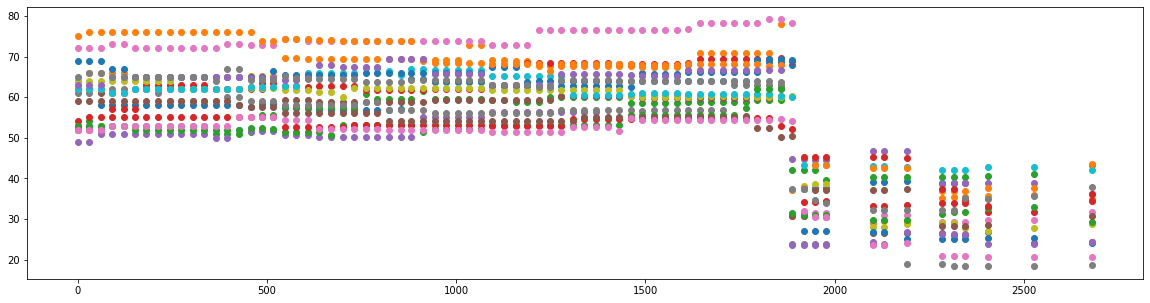

In [54]:
price_df, esg_pivot, sector_classification = fetch_raw_data("C:/Users/User/Code/MMD_Graph_Diversification/")
ind = esg_pivot.loc[:,np.isin(esg_pivot.columns, sector_classification['Energy'])]

fig, ax = plt.subplots(1,1, figsize = (20,5))
for i in range(ind.shape[1]):

    ax.scatter(range(ind.shape[0]),ind.iloc[:,i])

In [55]:
gp_esg_stock = pd.read_pickle('../data/tidy/gp_esg_stock_data_frame.pkl')
gp_esg_stock.index

Index([2014-10-01, 2014-10-02, 2014-10-03, 2014-10-04, 2014-10-05, 2014-10-06,
       2014-10-07, 2014-10-08, 2014-10-09, 2014-10-10,
       ...
       2022-01-23, 2022-01-24, 2022-01-25, 2022-01-26, 2022-01-27, 2022-01-28,
       2022-01-29, 2022-01-30, 2022-01-31, 2022-02-01],
      dtype='object', name='date', length=2681)

In [35]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
spectralGraphTopology = importr('spectralGraphTopology')
igraph = importr('igraph')
fingraph = importr('fingraph')
fitHeavyTail = importr('fitHeavyTail')
huge = importr('huge')

robjects.r('''

library(huge)

huge.glasso = function(x, scale = FALSE, lambda = NULL, lambda.min.ratio = NULL, nlambda = NULL, scr = NULL, cov.output = FALSE, verbose = TRUE){

  gcinfo(FALSE)
  n = nrow(x)
  d = ncol(x)
  cov.input = isSymmetric(x)
  if(cov.input)
  {
    if(verbose) cat("The input is identified as the covariance matrix.\n")
    S = x
  }
  else
  {
    if(scale){
      print("SCALE")
      x = scale(x)
    S = cor(x)
    }else{
    print("my_method")
    S = cov(x)
    }

  }
  rm(x)
  gc()
  if(is.null(scr)) scr = FALSE
  if(!is.null(lambda)) nlambda = length(lambda)
  if(is.null(lambda))
  {
    if(is.null(nlambda))
      nlambda = 10
    if(is.null(lambda.min.ratio))
      lambda.min.ratio = 0.1
    lambda.max = max(max(S-diag(d)),-min(S-diag(d)))
    lambda.min = lambda.min.ratio*lambda.max
    lambda = exp(seq(log(lambda.max), log(lambda.min), length = nlambda))
  }

  fit = .Call("_huge_hugeglasso",S,lambda,scr,verbose,cov.output,PACKAGE="huge")

  fit$scr = scr
  fit$lambda = lambda
  fit$cov.input = cov.input
  fit$cov.output = cov.output

  rm(S)
  gc()
  if(verbose){
       cat("\nConducting the graphical lasso (glasso)....done.                                          \r")
       cat("\n")
      flush.console()
  }
  return(fit)
}

huge = function(x, scale = scale, lambda = NULL, nlambda = NULL, lambda.min.ratio = NULL, method = "mb", scr = NULL, scr.num = NULL, cov.output = FALSE, sym = "or", verbose = TRUE)
{
	gcinfo(FALSE)
	est = list()
	est$method = method

	if(method == "ct")
	{
		fit = huge.ct(x, nlambda = nlambda, lambda.min.ratio = lambda.min.ratio, lambda = lambda, verbose = verbose)
		est$path = fit$path
		est$lambda = fit$lambda
		est$sparsity = fit$sparsity
		est$cov.input = fit$cov.input
		rm(fit)
		gc()
	}

	if(method == "mb")
	{
		fit = huge.mb(x, lambda = lambda, nlambda = nlambda, lambda.min.ratio = lambda.min.ratio, scr = scr, scr.num = scr.num, sym = sym, verbose = verbose)
		est$path = fit$path
		est$beta = fit$beta
		est$lambda = fit$lambda
		est$sparsity = fit$sparsity
		est$df = fit$df
		est$idx_mat = fit$idx_mat
		est$sym = sym
		est$scr = fit$scr
		est$cov.input = fit$cov.input
		rm(fit,sym)
		gc()
	}


	if(method == "glasso")
	{
		fit = huge.glasso(x, scale = scale, nlambda = nlambda, lambda.min.ratio = lambda.min.ratio, lambda = lambda, scr = scr, cov.output = cov.output, verbose = verbose)
		est$path = fit$path
		est$lambda = fit$lambda
		est$icov = fit$icov
		est$df = fit$df
		est$sparsity = fit$sparsity
		est$loglik = fit$loglik
		if(cov.output)
			est$cov = fit$cov
		est$cov.input = fit$cov.input
		est$cov.output = fit$cov.output
		est$scr = fit$scr
		rm(fit)
		gc()
	}

	if(method == "tiger")
	{
	  fit = huge.tiger(x, lambda = lambda, nlambda = nlambda, lambda.min.ratio = lambda.min.ratio, sym = sym, verbose = verbose)
	  est$path = fit$path
	  est$lambda = fit$lambda
	  est$sparsity = fit$sparsity
	  est$df = fit$df
	  est$idx_mat = fit$idx_mat
	  est$sym = sym
	  est$scr = fit$scr
	  est$cov.input = fit$cov.input
	  est$icov = fit$icov;
	  rm(fit,sym)
	  gc()
	}

	est$data = x

	rm(x,scr,lambda,lambda.min.ratio,nlambda,cov.output,verbose)
	gc()
	class(est) = "huge"
	return(est)
}

my_huge <- function(X, gamma = 0.1, lamda = exp(seq(log(1e-3), log(1e-7), length = 50)),scale = FALSE){

    out.glasso = huge(X, scale = scale, lambda = lamda, method = "glasso")
    return(huge.select(out.glasso, criterion = "ebic",ebic.gamma = 0.1 ))


}



''')

my_huge = robjects.globalenv["my_huge"]


Unable to determine R library path: Command '('C:\\PROGRA~1\\R\\R-41~1.3\\bin\\Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.


In [57]:

import warnings


asset_dict = {'Industrials':sector_classification['Industrials']}
k = 'Industrials'
all_stocks_in_sector =asset_dict[k]
stocks_considered = {}

price_df = price_df.loc[:, np.isin(price_df.columns,asset_dict[k])]
esg_df = gp_esg_stock.loc[:, np.isin(gp_esg_stock.columns,asset_dict[k])]


nr_splits = 3
window_size = 300
k = 'Industrials'
stock_partition = {i: [] for i in range(nr_splits)}
scale = False

dates4 = []

i = 500

transform = None
graph_dict = {i: [] for i in range(nr_splits)} 
graph_estimation = 'huge_glasso_ebic'
lamda = np.exp(np.linspace(start = np.log(1e-3), stop = np.log(1e-7), num = 100))
nlambda = len(lamda)



def create_G(A:np.array):
  """
  Label graph
  A adjacency matrix as nx
  """
  G = nx.from_numpy_array(A)
  # set sign labels
  nx.set_edge_attributes(G, {(n1, n2): np.sign(val) for n1, n2, val in G.edges.data('weight')}, "sign")
  nodes_degree = dict(G.degree)
  # set degree as label
  nx.set_node_attributes(G, {key: str(value) for key, value in nodes_degree.items()}, "label")
  return G 

# remove data not obtained
min_max_date = np.min([np.max(price_df.index), np.max(esg_df.index)])
price_df=price_df.loc[price_df.index <= min_max_date]
for i in tqdm.tqdm(range(window_size, price_df.shape[0], 2)): #price_df.shape[0]
  # At first iteration determine which stocks in the sector will be considered.
  # If the total number of stocks in the sector are not divisible by nr_splits
  # then the first stocks which correspond to the reminder of the division will be omitted
  # in future iterations only the stocks in stocks_considered will be used
  if stocks_considered.get(k,None) is None:
      stocks_in_sector = price_df.columns[np.isin(price_df.columns,all_stocks_in_sector)]
      esg_stocks_in_sector = esg_df.columns[np.isin(esg_df.columns,all_stocks_in_sector)]

      stocks_considered[k] = stocks_in_sector.intersection(esg_stocks_in_sector)
      print(f'{k} has {len(stocks_considered[k])} stocks')
      

      if len(stocks_considered[k]) % nr_splits != 0:
          res = len(stocks_considered[k]) % nr_splits
          print(f'{k} dropped {stocks_considered[k][:res]}')
          stocks_considered[k] = stocks_considered[k][res:]

  # get esg scores of the stocks for the current iteration
  esg_i = np.array(esg_df[stocks_considered[k]].loc[esg_df.index == price_df.index[i]].iloc[0,:])

  # get snp500 index for current iteration, used in  
  # snp500_i = np.array(sp500.loc[np.isin(sp500.date,price_pivot.iloc[(i-window_size):i].index), 'log_return'])
  # order stocks
  stocks_ordered_i = np.array(stocks_considered[k][np.argsort(esg_i)])
  # get date of the iteration i
  date_i = price_df.index[i]


  # Store date
  dates4.append(date_i)
  # create a dummy index so we can access the correct stocke later on
  stocks_indexes = np.array(range(len(stocks_considered[k])))


  # for i_split, stocks_index in enumerate(np.array_split(stocks_indexes, nr_splits)):

  #       # If nr_splits is 3 and number of stocks is 30, 
  #       # the at first iteration stocks_index = [0,2,...,9]
  #       # second iteration stocks_index = [10,2,...,19]
  #       # third iteration stocks_index = [20,2,...,29]

  #       # select the stocks in this split and only select the time for this rolling window
        
  #       if transform is None:
  #         stock_split_i = np.array(price_df[stocks_ordered_i[stocks_index]].iloc[(i-window_size):i])
  #       elif transform == 'nonparanormal':
  #         stock_split_i = price_df[stocks_ordered_i[stocks_index]].iloc[(i-window_size):i]
  #         mu_tmp = np.array(stock_split_i.mean())
  #         S_tmp = np.array(stock_split_i.cov())
  #         stock_split_i = huge.huge_npn(np.array(stock_split_i) , npn_func="truncation")
  #         # convert to correct scale again
  #         stock_split_i = (stock_split_i*np.sqrt(np.diag(S_tmp)) + mu_tmp)
  #       else:
  #         raise ValueError(f"No transform called {transform}")
        
  #       # get standar deviation of each asset
  #       var = np.diag(np.cov(stock_split_i.T))
  #       if i == window_size:
  #         print(var.shape)



  #       stock_partition[i_split].append(stocks_ordered_i[stocks_index])

  #       if i == window_size and i_split == 0:
  #         print(f"First iteration of {k}. Shape is {stock_split_i.shape}")

  #       X = np.array(stock_split_i)
        
  #       try:
  #         if graph_estimation == 'huge_glasso_ebic':
  #           # out = huge.huge(X, method = 'glasso', nlambda = nlambda,verbose = False, lambda_min_ratio = 0.001)
  #           # out_select = huge.huge_select(out, criterion = "ebic",ebic_gamma = 0.1 )
  #           # out_select = dict(zip(out_select.names, list(out_select)))
  #           out_select = my_huge(X, gamma = 0.01, lamda = lamda, scale = scale)
  #           out_select = dict(zip(out_select.names, list(out_select)))
  #           where_optimal = int(np.where(out_select['opt.lambda'][0] == out_select['lambda'])[0][0])
  #           print(where_optimal)
  #           if (where_optimal == nlambda-1) or (where_optimal == 0):
  #             warnings.warn("Warning optimal graph is last or first regularization parameter")
  #           precision_matrix = out_select['opt.icov'].copy()
  #           precision_matrix_no_diag = precision_matrix.copy()
  #           np.fill_diagonal(precision_matrix_no_diag,0)
  #           G = create_G(-precision_matrix_no_diag)
  #           graph_dict[i_split].append(G)

  #       except:

  #         break


 31%|███       | 244/784 [00:00<00:00, 1220.72it/s]

Industrials has 60 stocks


100%|██████████| 784/784 [00:00<00:00, 1255.11it/s]


In [44]:
np.sum(esg_df.index == price_df.index[i]

datetime.date(2022, 2, 2)

In [38]:
where_optimal

52

# Individual TEST - INDUSTRIALS

In [159]:
with open(f'../data/Graphs/TEST_d_1_winlen_300_gest_huge_glasso_ebic_scale_False_trans_nonparanormal.pkl', 'rb') as f:
    scale_F_nonparanormal = pickle.load(f)
with open(f'../data/Graphs/TEST_d_1_winlen_300_gest_huge_glasso_ebic_scale_True_trans_nonparanormal.pkl', 'rb') as f:
    scale_T_nonparanormal = pickle.load(f)
with open(f'../data/Graphs/TEST_d_1_winlen_300_gest_huge_glasso_ebic_scale_False_trans_None.pkl', 'rb') as f:
    scale_F_none = pickle.load(f)
with open(f'../data/Graphs/TEST_d_1_winlen_300_gest_huge_glasso_ebic_scale_True_trans_None.pkl', 'rb') as f:
    scale_T_none = pickle.load(f)


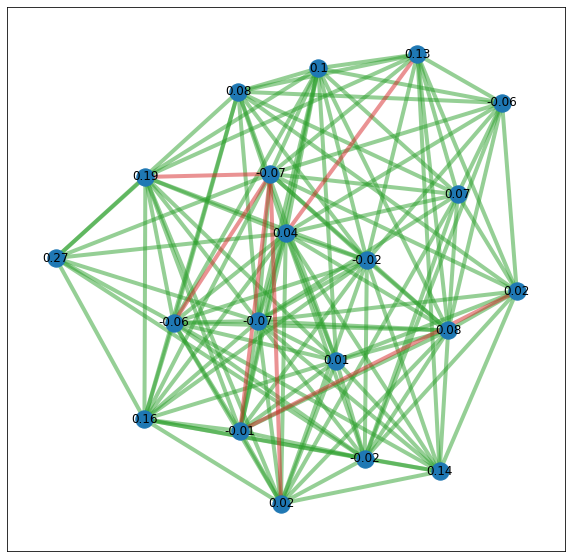

In [74]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
G = scale_F_nonparanormal[0]['graph_dict'][0][50]
w = scale_F_nonparanormal[0]['portfolios_info']['gmv']['weights'][0][50]
pos_edge = [(edge[0], edge[1]) for edge in G.edges(data = 'sign') if edge[2] == 1]
neg_edge = [(edge[0], edge[1]) for edge in G.edges(data = 'sign') if edge[2] == -1]
pos = nx.kamada_kawai_layout( G, weight=None)

nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G,pos,{i:np.round(w[i], 2) for i in range(len(w))})
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=pos_edge,
    width=4,
    alpha=0.5,
    edge_color="tab:green",
)

nx.draw_networkx_edges(
    G,
    pos,
    edgelist=neg_edge,
    width=4,
    alpha=0.5,
    edge_color="tab:red",
)

NameError: name 'data_dict' is not defined

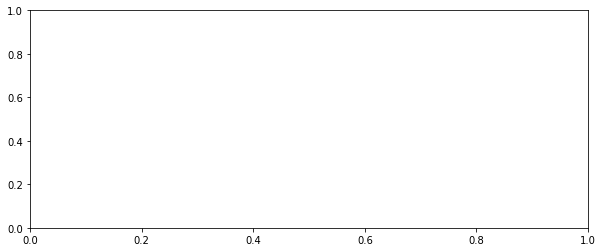

In [76]:
fig,ax = plt.subplots(1,1, figsize = (10,4))
ax.plot(data_dict[0]['dates'][index], [avg_degree(G1[i], None) for i in range(len(G1))])
ax.plot(data_dict[0]['dates'][index], [avg_degree(G2[i], None) for i in range(len(G2))])

fig,ax = plt.subplots(1,1, figsize = (10,4))
ax.plot(data_dict[0]['dates'][index], [cnt_pos_neg(G1[i], 1) for i in range(len(G1))], color = "DarkGreen")
ax.plot(data_dict[0]['dates'][index], [cnt_pos_neg(G1[i], -1) for i in range(len(G1))], color = "lightgreen")

ax.plot(data_dict[0]['dates'][index], [cnt_pos_neg(G2[i], 1) for i in range(len(G2))], color = "Darkred")
ax.plot(data_dict[0]['dates'][index], [cnt_pos_neg(G2[i], -1) for i in range(len(G2))], color = "pink")

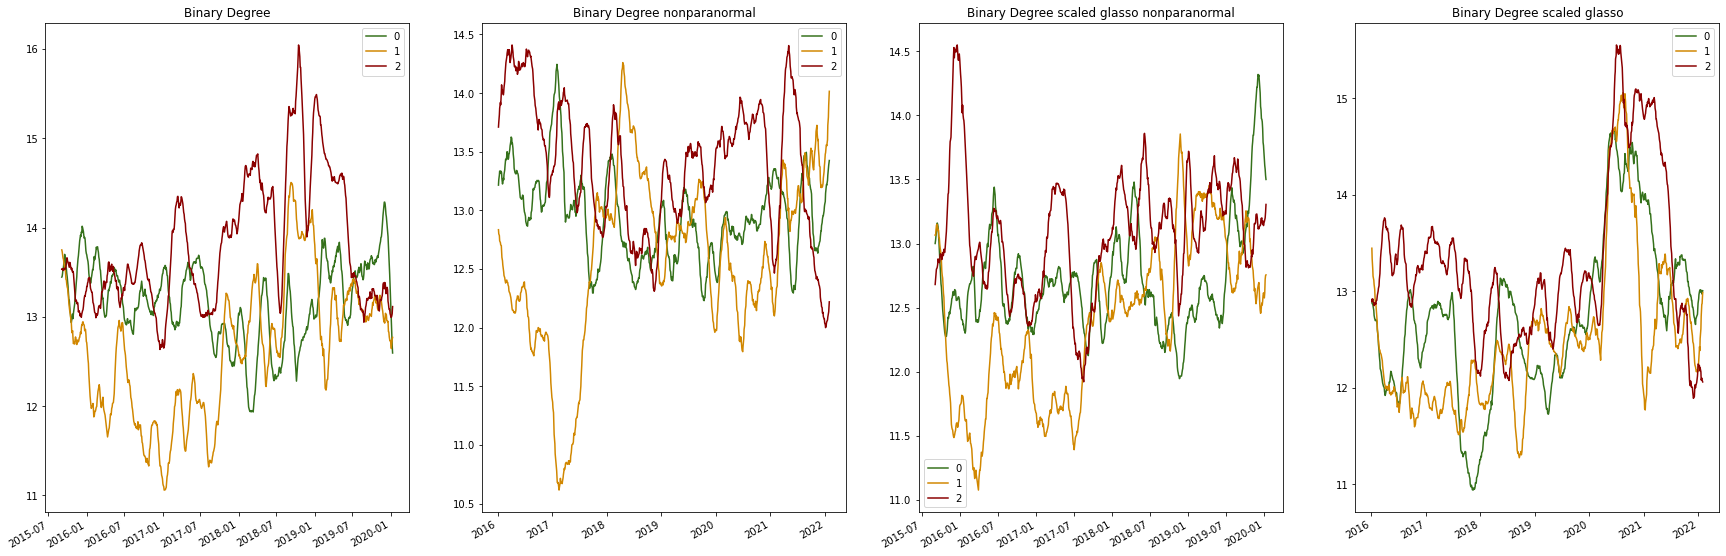

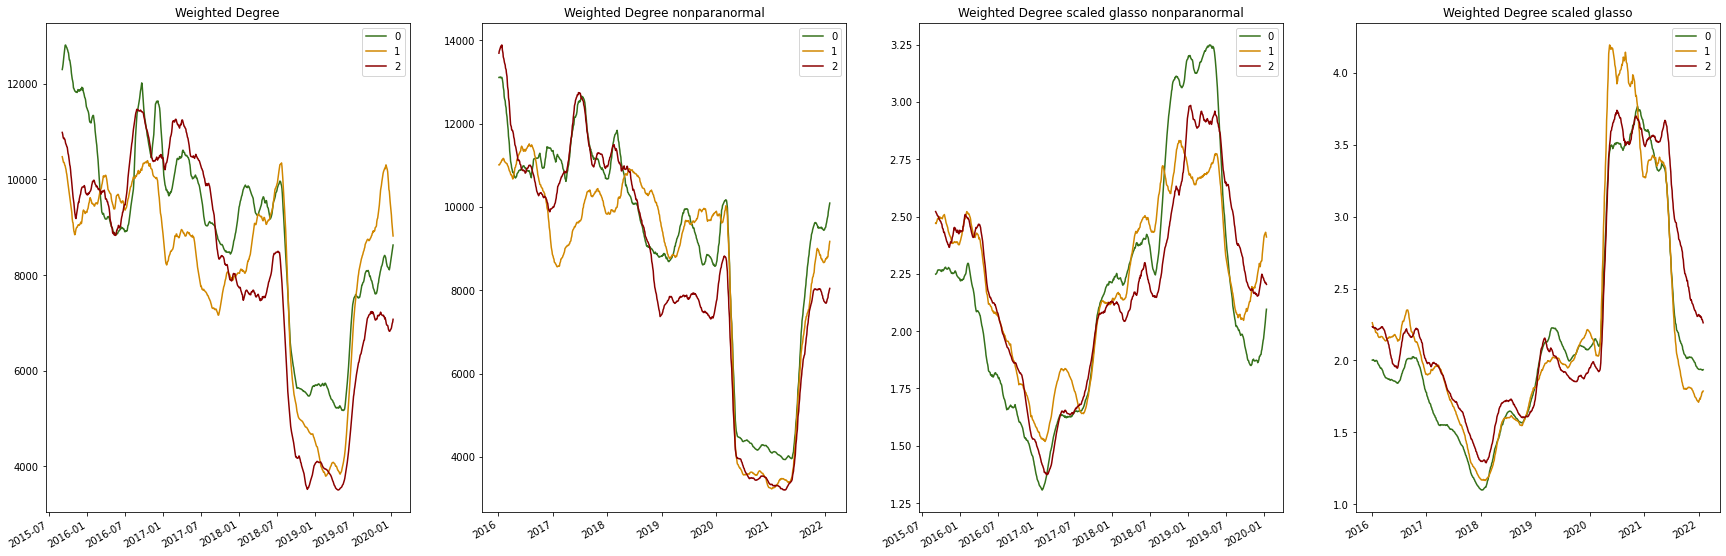

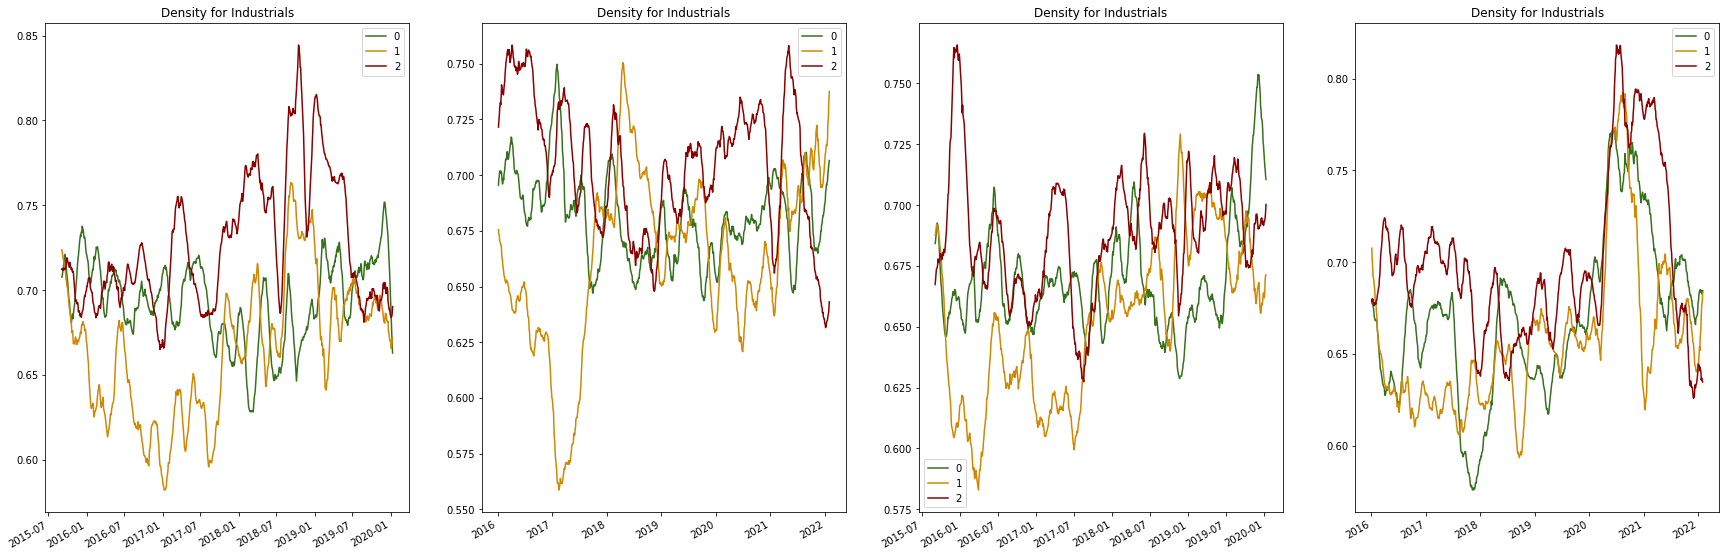

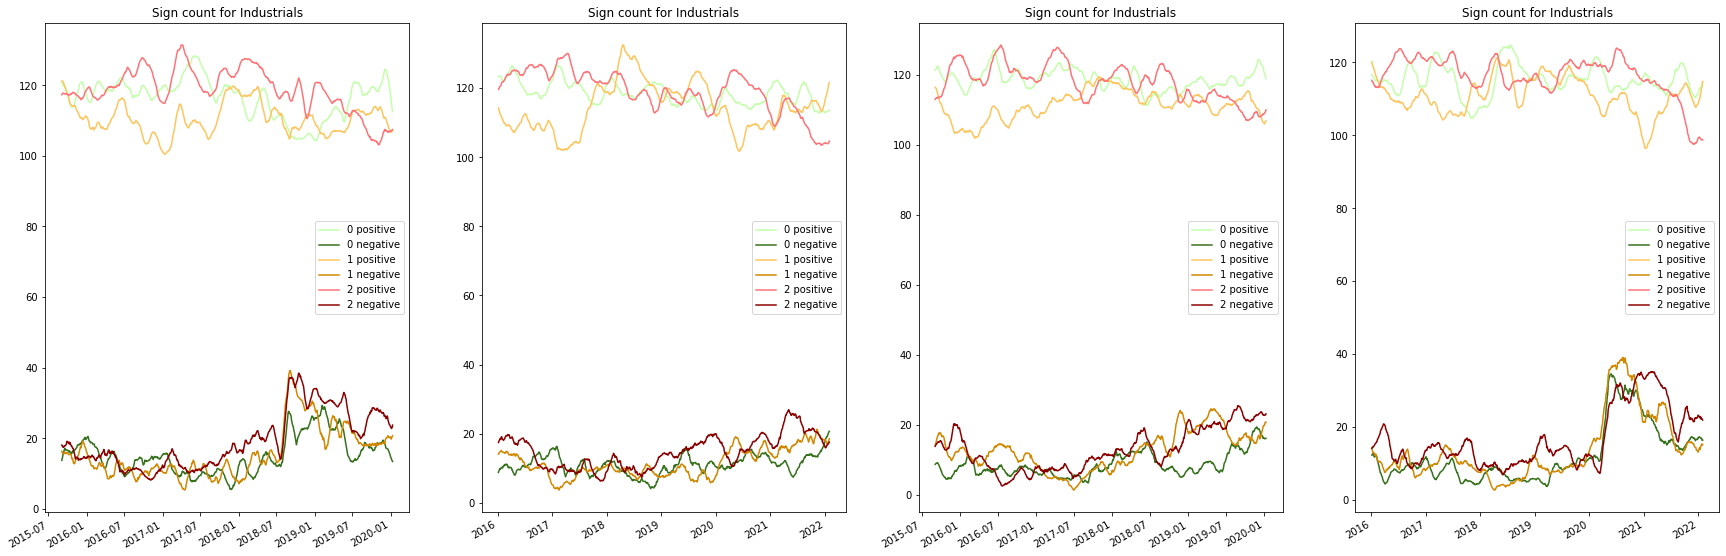

In [160]:
rw = 20
for idx in range(len(scale_F_nonparanormal)):
    fig, ax = plt.subplots(1,4, figsize = (30,10))
    plot_avg_degree(scale_F_none[idx], ax = ax[0], title = f'Binary Degree', rolling_window= rw)
    plot_avg_degree(scale_F_nonparanormal[idx], ax = ax[1], title = f'Binary Degree nonparanormal', rolling_window= rw)
    plot_avg_degree(scale_T_nonparanormal[idx], ax = ax[2], title = f'Binary Degree scaled glasso nonparanormal', rolling_window= rw)
    plot_avg_degree(scale_T_none[idx], ax = ax[3], title = f'Binary Degree scaled glasso', rolling_window= rw)
    fig.autofmt_xdate()

    fig, ax = plt.subplots(1,4, figsize = (30,10))
    plot_avg_degree(scale_F_none[idx], weight = 'weight', ax = ax[0], title = f'Weighted Degree', rolling_window= rw)
    plot_avg_degree(scale_F_nonparanormal[idx], weight = 'weight', ax = ax[1], title = f'Weighted Degree nonparanormal', rolling_window= rw)
    plot_avg_degree(scale_T_nonparanormal[idx], weight = 'weight', ax = ax[2], title = f'Weighted Degree scaled glasso nonparanormal', rolling_window= rw)
    plot_avg_degree(scale_T_none[idx], weight = 'weight', ax = ax[3], title = f'Weighted Degree scaled glasso', rolling_window= rw)
    fig.autofmt_xdate()

    fig, ax = plt.subplots(1,4, figsize = (30,10))
    plot_G_density(scale_F_none[idx],  ax = ax[0],  rolling_window= rw)
    plot_G_density(scale_F_nonparanormal[idx], ax = ax[1], rolling_window= rw)
    plot_G_density(scale_T_nonparanormal[idx],  ax = ax[2], rolling_window= rw)
    plot_G_density(scale_T_none[idx],  ax = ax[3], rolling_window= rw)
    fig.autofmt_xdate()

    fig, ax = plt.subplots(1,4, figsize = (30,10))
    plot_G_signs(scale_F_none[idx],  ax = ax[0],  rolling_window= rw)
    plot_G_signs(scale_F_nonparanormal[idx], ax = ax[1], rolling_window= rw)
    plot_G_signs(scale_T_nonparanormal[idx],  ax = ax[2], rolling_window= rw)
    plot_G_signs(scale_T_none[idx],  ax = ax[3], rolling_window= rw)
    fig.autofmt_xdate()

    # fig, ax = plt.subplots(1,4, figsize = (30,10))
    # plot_weight_signs(scale_F_none[idx],  ax = ax[0],  rolling_window= rw)
    # plot_weight_signs(scale_F_nonparanormal[idx], ax = ax[1], rolling_window= rw)
    # plot_weight_signs(scale_T_nonparanormal[idx],  ax = ax[2], rolling_window= rw)
    # plot_weight_signs(scale_T_none[idx],  ax = ax[3], rolling_window= rw)
    # fig.autofmt_xdate()


Compare best graph vs almost best

ESG dispersion

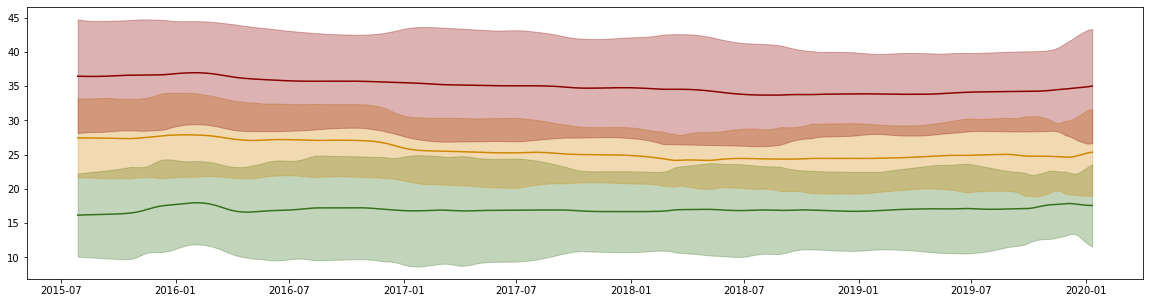

In [42]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(scale_F_nonparanormal[0]['dates'], scale_F_nonparanormal[0]['esg_mean'][0], color = color_dark[0])
ax.fill_between(
    scale_F_nonparanormal[0]['dates'].ravel(),
    np.array(scale_F_nonparanormal[0]['esg_mean'][0]) - 1.96 * np.array(scale_F_nonparanormal[0]['esg_std'][0]),
    np.array(scale_F_nonparanormal[0]['esg_mean'][0]) + 1.96 * np.array(scale_F_nonparanormal[0]['esg_std'][0]),
    alpha=0.3,
    color = color_dark[0]
)

ax.plot(scale_F_nonparanormal[0]['dates'], scale_F_nonparanormal[0]['esg_mean'][1], color = color_dark[1])
ax.fill_between(
    scale_F_nonparanormal[0]['dates'].ravel(),
    np.array(scale_F_nonparanormal[0]['esg_mean'][1]) - 1.96 * np.array(scale_F_nonparanormal[0]['esg_std'][1]),
    np.array(scale_F_nonparanormal[0]['esg_mean'][1]) + 1.96 * np.array(scale_F_nonparanormal[0]['esg_std'][1]),
    alpha=0.3,
    color = color_dark[1]
)

ax.plot(scale_F_nonparanormal[0]['dates'], scale_F_nonparanormal[0]['esg_mean'][2], color = color_dark[2])
ax.fill_between(
    scale_F_nonparanormal[0]['dates'].ravel(),
    np.array(scale_F_nonparanormal[0]['esg_mean'][2]) - 1.96 * np.array(scale_F_nonparanormal[0]['esg_std'][2]),
    np.array(scale_F_nonparanormal[0]['esg_mean'][2]) + 1.96 * np.array(scale_F_nonparanormal[0]['esg_std'][2]),
    alpha=0.3,
    color = color_dark[2]
)

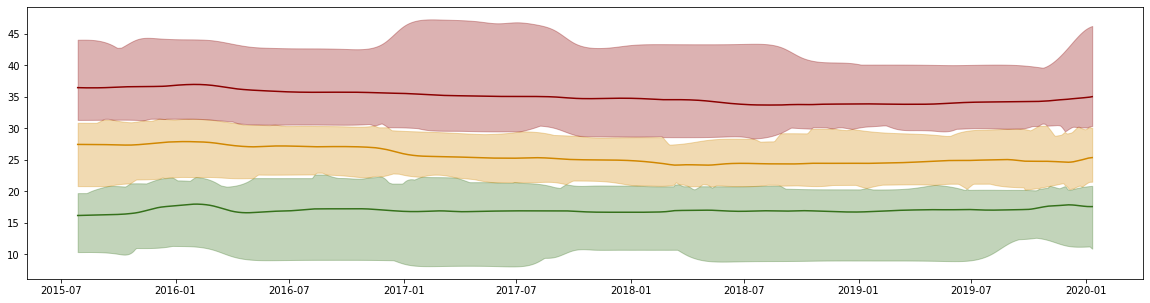

In [128]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(scale_F_nonparanormal[0]['dates'], scale_F_nonparanormal[0]['esg_mean'][0], color = color_dark[0])
ax.fill_between(
    scale_F_nonparanormal[0]['dates'].ravel(),
    np.array(scale_T_nonparanormal[0]['esg_max'][0]) ,
    np.array(scale_T_nonparanormal[0]['esg_min'][0]),
    alpha=0.3,
    color = color_dark[0]
)

ax.plot(scale_F_nonparanormal[0]['dates'], scale_F_nonparanormal[0]['esg_mean'][1], color = color_dark[1])
ax.fill_between(
    scale_F_nonparanormal[0]['dates'].ravel(),
    np.array(scale_T_nonparanormal[0]['esg_max'][1]) ,
    np.array(scale_T_nonparanormal[0]['esg_min'][1]),
    alpha=0.3,
    color = color_dark[1]
)

ax.plot(scale_F_nonparanormal[0]['dates'], scale_F_nonparanormal[0]['esg_mean'][2], color = color_dark[2])
ax.fill_between(
    scale_F_nonparanormal[0]['dates'].ravel(),
    np.array(scale_T_nonparanormal[0]['esg_max'][2]) ,
    np.array(scale_T_nonparanormal[0]['esg_min'][2]),
    alpha=0.3,
    color = color_dark[2]
)

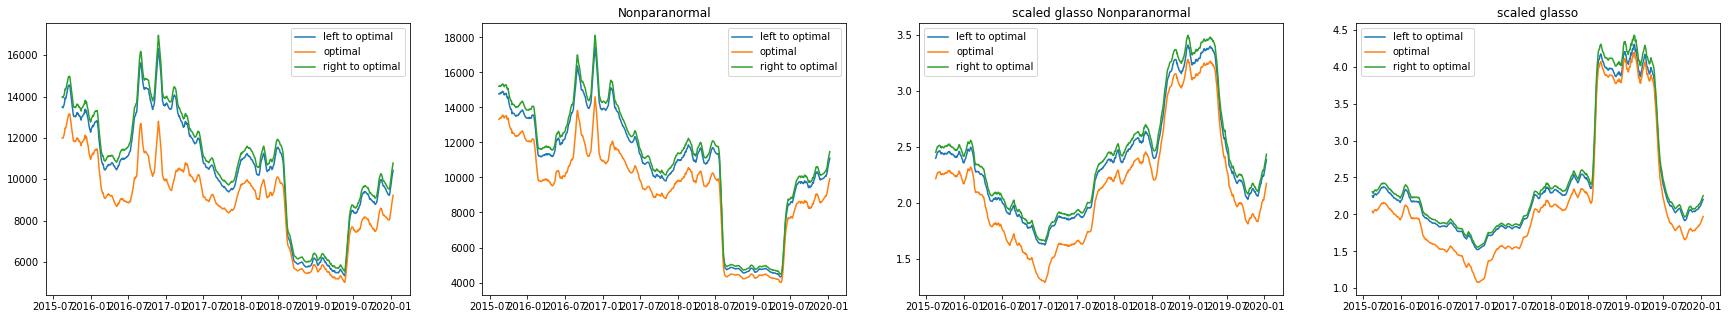

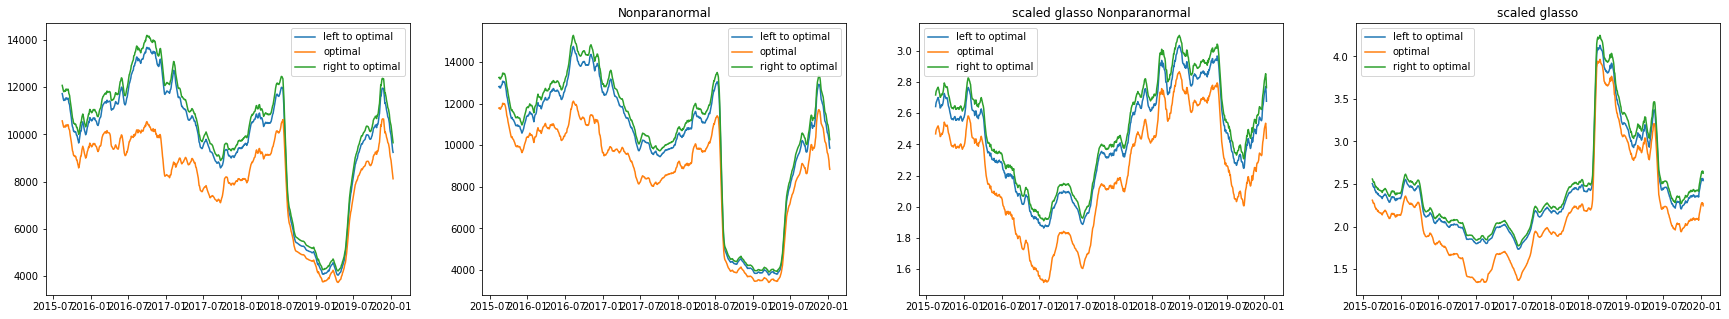

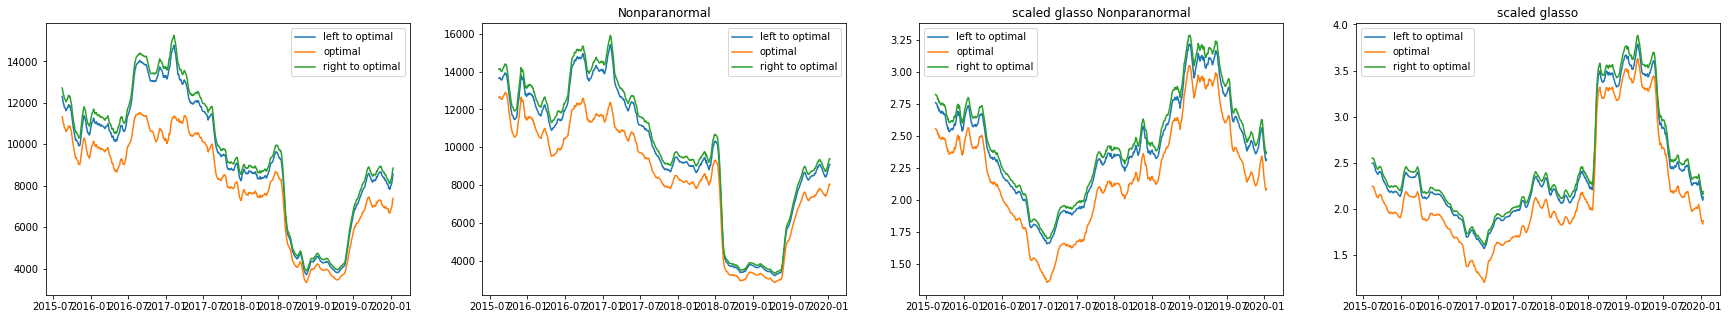

In [141]:
def compare_best_next(df, ax, group, title = '', weight = 'weight'):
    i = group
    # minus one
    avg_degree_dict = [avg_degree(nx.from_numpy_array(df[0]['prec_dict_minus_1'][i][j]), weight) for j in range(len(df[0]['prec_dict_minus_1'][i]))]
    ax.plot(df[0]['dates'], pd.DataFrame(avg_degree_dict).rolling(10).mean().iloc[:,0], label = 'left to optimal')
    # best
    avg_degree_dict = [avg_degree(df[0]['graph_dict'][i][j], weight) for j in range(len(df[0]['prec_dict_minus_1'][i]))]
    ax.plot(df[0]['dates'], pd.DataFrame(avg_degree_dict).rolling(10).mean().iloc[:,0], label = 'optimal')
    # plus one
    avg_degree_dict = [avg_degree(nx.from_numpy_array(g), weight) if type(g) is not float else np.nan for j, g in enumerate(df[0]['prec_dict_plus_1'][i])]
    ax.plot(df[0]['dates'], pd.DataFrame(avg_degree_dict).rolling(10).mean().iloc[:,0], label = 'right to optimal')
    ax.set_title(title)
    ax.legend()

weight = 'weight'
fig, ax = plt.subplots(1,4, figsize = (30,5))
compare_best_next(scale_F_none, ax = ax[0], group=0, weight = weight)
compare_best_next(scale_F_nonparanormal, ax = ax[1], group=0, title = f'Nonparanormal', weight = weight)
compare_best_next(scale_T_nonparanormal, ax = ax[2], group=0,  title = f'scaled glasso Nonparanormal', weight = weight)
compare_best_next(scale_T_none, ax = ax[3], group=0,  title = f'scaled glasso', weight = weight)
fig.autofmt_xdate()
fig, ax = plt.subplots(1,4, figsize = (30,5))
compare_best_next(scale_F_none, ax = ax[0], group=1, weight = weight)
compare_best_next(scale_F_nonparanormal, ax = ax[1], group=1, title = f'Nonparanormal', weight = weight)
compare_best_next(scale_T_nonparanormal, ax = ax[2], group=1,  title = f'scaled glasso Nonparanormal', weight = weight)
compare_best_next(scale_T_none, ax = ax[3], group=1,  title = f'scaled glasso', weight = weight)
fig.autofmt_xdate()
fig, ax = plt.subplots(1,4, figsize = (30,5))
compare_best_next(scale_F_none, ax = ax[0], group=2, weight = weight)
compare_best_next(scale_F_nonparanormal, ax = ax[1], group=2, title = f'Nonparanormal', weight = weight)
compare_best_next(scale_T_nonparanormal, ax = ax[2], group=2,  title = f'scaled glasso Nonparanormal', weight = weight)
compare_best_next(scale_T_none, ax = ax[3], group=2,  title = f'scaled glasso', weight = weight)
fig.autofmt_xdate()




Some differences

In [17]:
ax[i].get_xticklabels()

[Text(16617.0, 0, '2015-07'),
 Text(16801.0, 0, '2016-01'),
 Text(16983.0, 0, '2016-07'),
 Text(17167.0, 0, '2017-01'),
 Text(17348.0, 0, '2017-07'),
 Text(17532.0, 0, '2018-01'),
 Text(17713.0, 0, '2018-07'),
 Text(17897.0, 0, '2019-01'),
 Text(18078.0, 0, '2019-07'),
 Text(18262.0, 0, '2020-01')]

portfolio

In [22]:
scale_F_none[0]['portfolios_info'][port_type]['cov_div'][0][:5]

[1.1960416875059428,
 1.216638864972919,
 1.2169017297051714,
 1.208069423249413,
 1.2115125011736412]

In [23]:
scale_F_nonparanormal[0]['portfolios_info'][port_type]['cov_div'][0][:5]

[1.213674862303761,
 1.229920586608812,
 1.2276249803835786,
 1.2250088142298423,
 1.2216889184363229]

In [24]:
scale_T_nonparanormal[0]['portfolios_info'][port_type]['cov_div'][0][:5]

[1.202061098561781,
 1.2201471727546387,
 1.2175972177359706,
 1.2166012321450124,
 1.2103713112521832]

In [25]:
scale_T_none[0]['portfolios_info'][port_type]['cov_div'][0][:5]

[1.1768925558806804,
 1.1942956158502291,
 1.1958404521227373,
 1.1945010868043529,
 1.1941604033265476]

In [31]:
np.array(color_dark)[[0,2]]

array(['#35711b', '#8B0000'], dtype='<U7')

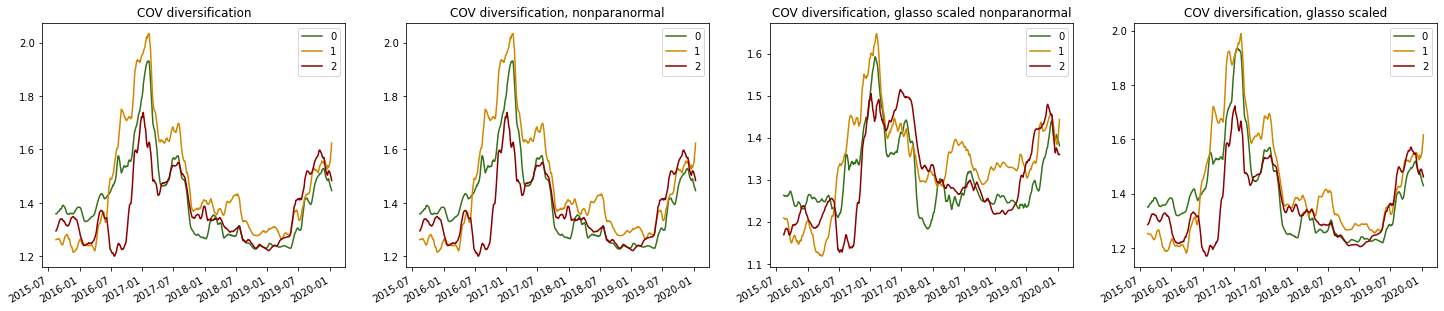

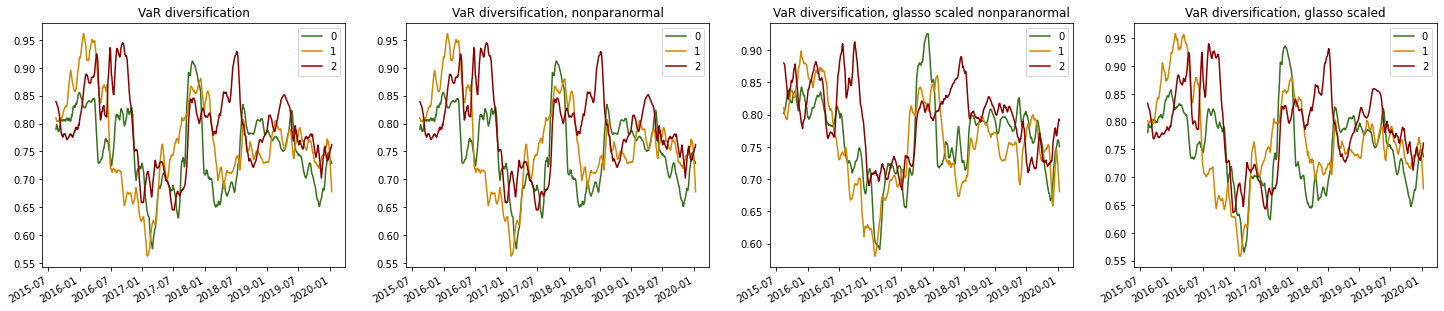

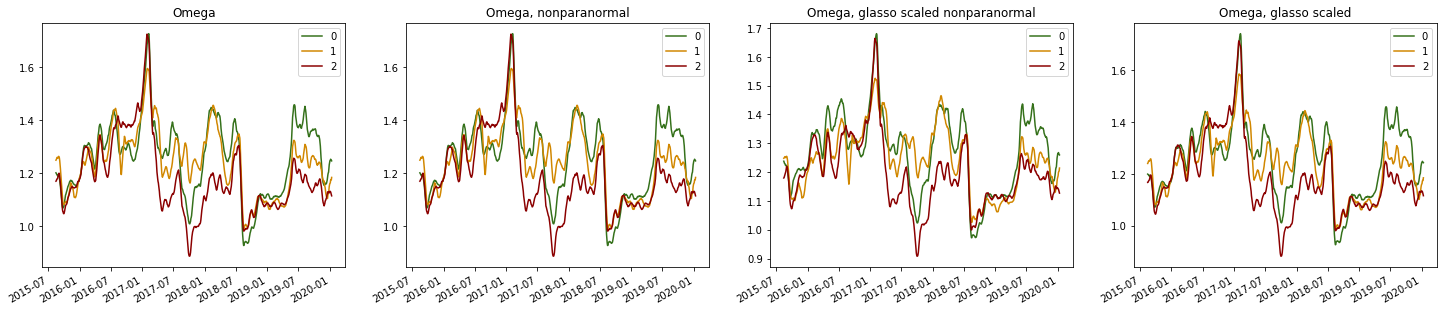

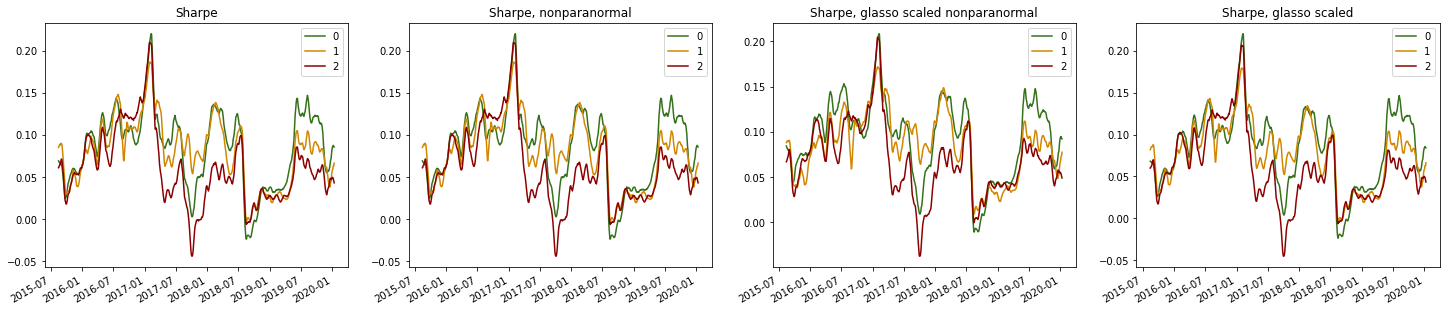

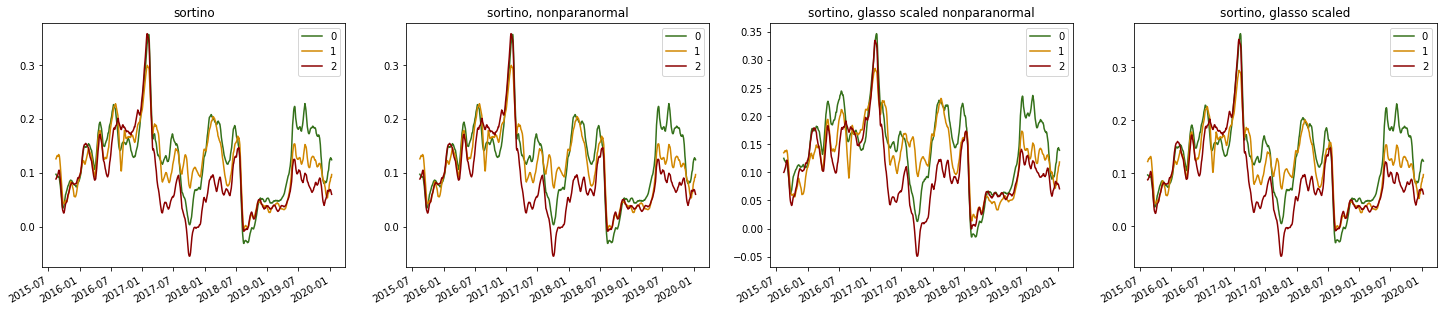

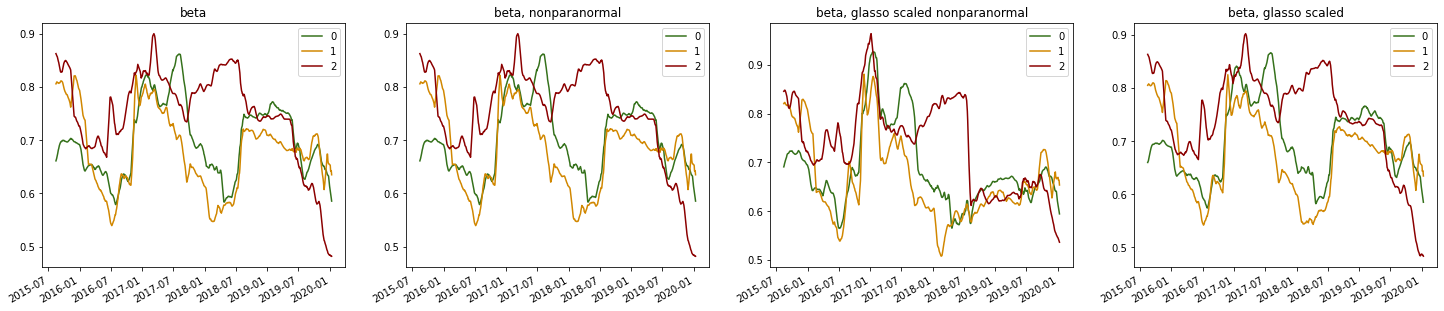

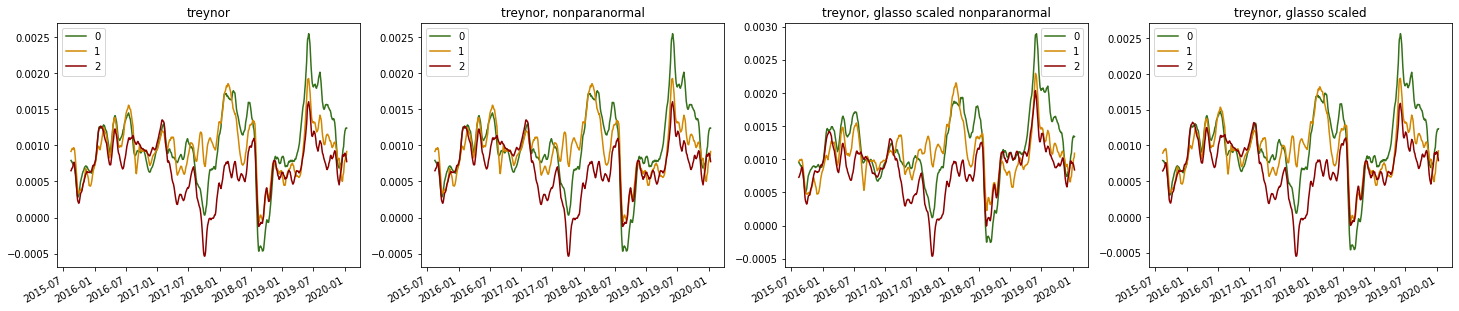

In [119]:
sector = 'Industrials'
port_type = 'gmv'
fig, ax = plt.subplots(1,4, figsize = (25,5))
rmean = 10
pd.DataFrame(scale_F_none[0]['portfolios_info'][port_type]['cov_div'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[0], color = color_dark, title = f'COV diversification')
pd.DataFrame(scale_F_nonparanormal[0]['portfolios_info'][port_type]['cov_div'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[1], color = color_dark, title = f'COV diversification, nonparanormal')
pd.DataFrame(scale_T_nonparanormal[0]['portfolios_info'][port_type]['cov_div'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[2], color = color_dark, title = f'COV diversification, glasso scaled nonparanormal')
pd.DataFrame(scale_T_none[0]['portfolios_info'][port_type]['cov_div'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[3], color = color_dark, title = f'COV diversification, glasso scaled')
fig.autofmt_xdate()

fig, ax = plt.subplots(1,4, figsize = (25,5))
pd.DataFrame(scale_F_none[0]['portfolios_info'][port_type]['var_div'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[0], color = color_dark, title = f'VaR diversification')
pd.DataFrame(scale_F_nonparanormal[0]['portfolios_info'][port_type]['var_div'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[1], color = color_dark, title = f'VaR diversification, nonparanormal')
pd.DataFrame(scale_T_nonparanormal[0]['portfolios_info'][port_type]['var_div'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[2], color = color_dark, title = f'VaR diversification, glasso scaled nonparanormal')
pd.DataFrame(scale_T_none[0]['portfolios_info'][port_type]['var_div'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[3], color = color_dark, title = f'VaR diversification, glasso scaled')
fig.autofmt_xdate()

fig, ax = plt.subplots(1,4, figsize = (25,5))
pd.DataFrame(scale_F_none[0]['portfolios_info'][port_type]['omega'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[0], color = color_dark, title = f'Omega')
pd.DataFrame(scale_F_nonparanormal[0]['portfolios_info'][port_type]['omega'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[1], color = color_dark, title = f'Omega, nonparanormal')
pd.DataFrame(scale_T_nonparanormal[0]['portfolios_info'][port_type]['omega'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[2], color = color_dark, title = f'Omega, glasso scaled nonparanormal')
pd.DataFrame(scale_T_none[0]['portfolios_info'][port_type]['omega'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[3], color = color_dark, title = f'Omega, glasso scaled')
fig.autofmt_xdate()

fig, ax = plt.subplots(1,4, figsize = (25,5))
pd.DataFrame(scale_F_none[0]['portfolios_info'][port_type]['sharpe'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[0], color = color_dark, title = f'Sharpe')
pd.DataFrame(scale_F_nonparanormal[0]['portfolios_info'][port_type]['sharpe'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[1], color = color_dark, title = f'Sharpe, nonparanormal')
pd.DataFrame(scale_T_nonparanormal[0]['portfolios_info'][port_type]['sharpe'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[2], color = color_dark, title = f'Sharpe, glasso scaled nonparanormal')
pd.DataFrame(scale_T_none[0]['portfolios_info'][port_type]['sharpe'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[3], color = color_dark, title = f'Sharpe, glasso scaled')
fig.autofmt_xdate()

fig, ax = plt.subplots(1,4, figsize = (25,5))
pd.DataFrame(scale_F_none[0]['portfolios_info'][port_type]['sortino'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[0], color = color_dark, title = f'sortino')
pd.DataFrame(scale_F_nonparanormal[0]['portfolios_info'][port_type]['sortino'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[1], color = color_dark, title = f'sortino, nonparanormal')
pd.DataFrame(scale_T_nonparanormal[0]['portfolios_info'][port_type]['sortino'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[2], color = color_dark, title = f'sortino, glasso scaled nonparanormal')
pd.DataFrame(scale_T_none[0]['portfolios_info'][port_type]['sortino'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[3], color = color_dark, title = f'sortino, glasso scaled')
fig.autofmt_xdate()

fig, ax = plt.subplots(1,4, figsize = (25,5))
pd.DataFrame(scale_F_none[0]['portfolios_info'][port_type]['beta'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[0], color = color_dark, title = f'beta')
pd.DataFrame(scale_F_nonparanormal[0]['portfolios_info'][port_type]['beta'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[1], color = color_dark, title = f'beta, nonparanormal')
pd.DataFrame(scale_T_nonparanormal[0]['portfolios_info'][port_type]['beta'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[2], color = color_dark, title = f'beta, glasso scaled nonparanormal')
pd.DataFrame(scale_T_none[0]['portfolios_info'][port_type]['beta'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[3], color = color_dark, title = f'beta, glasso scaled')
fig.autofmt_xdate()

fig, ax = plt.subplots(1,4, figsize = (25,5))
pd.DataFrame(scale_F_none[0]['portfolios_info'][port_type]['treynor'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[0], color = color_dark, title = f'treynor')
pd.DataFrame(scale_F_nonparanormal[0]['portfolios_info'][port_type]['treynor'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[1], color = color_dark, title = f'treynor, nonparanormal')
pd.DataFrame(scale_T_nonparanormal[0]['portfolios_info'][port_type]['treynor'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[2], color = color_dark, title = f'treynor, glasso scaled nonparanormal')
pd.DataFrame(scale_T_none[0]['portfolios_info'][port_type]['treynor'], index = scale_F_none[idx]['dates']).rolling(rmean).mean().plot(ax = ax[3], color = color_dark, title = f'treynor, glasso scaled')
fig.autofmt_xdate()



Seem to be very similar

In [95]:
np.vstack((scale_F_nonparanormal[0]['portfolios_info']['sharpe']['weights'][0][1:3],scale_F_nonparanormal[0]['portfolios_info']['sharpe']['weights'][1][1:3]))

array([[-0.00472105, -0.03424106,  0.0071609 , -0.01504634,  0.00954798,
        -0.02233529, -0.04425374, -0.01818127,  0.15195539, -0.07982554,
         0.07446312,  0.24155766,  0.03704418,  0.08623733,  0.25247599,
         0.09845079, -0.06779392,  0.0169035 ,  0.32420316, -0.01360179],
       [-0.00721411, -0.03384354, -0.00105504, -0.01466969, -0.0015524 ,
        -0.03361078, -0.03777268, -0.00790555,  0.12608142, -0.07185203,
         0.0889969 ,  0.21645931,  0.03179132,  0.0832453 ,  0.26518159,
        -0.08034976,  0.10875322,  0.03196024, -0.01017443,  0.3475307 ],
       [ 0.35533565, -0.00657875,  0.11136107, -0.02294735, -0.05619086,
        -0.03998965,  0.0348794 ,  0.25693203,  0.03015244, -0.01297213,
         0.17955484,  0.26720745, -0.02004501, -0.02783433,  0.04518367,
         0.01939344, -0.02719115, -0.01299294, -0.01003098, -0.06322685],
       [ 0.3877469 , -0.00193795,  0.10165039, -0.02223196, -0.0570793 ,
        -0.04498389,  0.02427678,  0.26848723,  

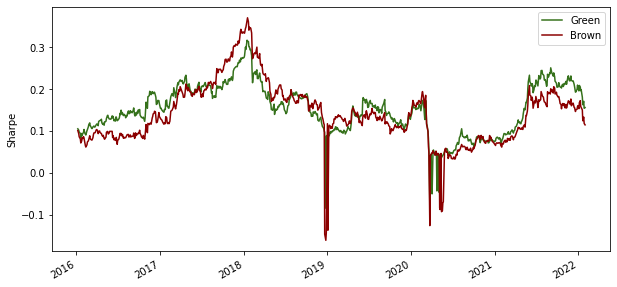

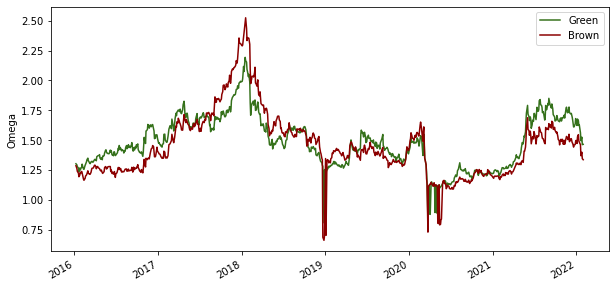

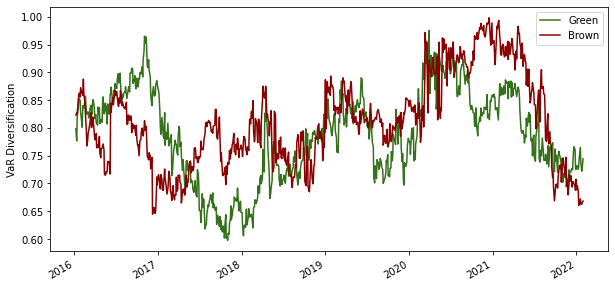

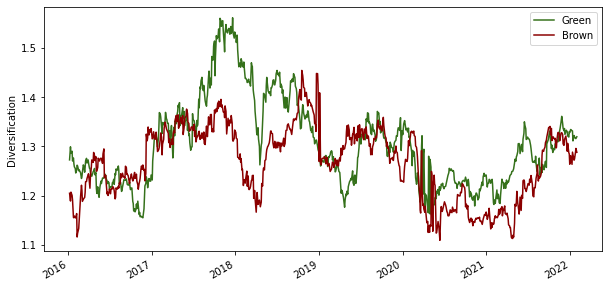

In [133]:
port_type = 'sharpe'

fig, ax = plt.subplots(1,1, figsize = (10,5))
rmean = 1
pd.DataFrame(scale_F_nonparanormal[0]['portfolios_info'][port_type]['sharpe'], index = scale_F_nonparanormal[idx]['dates']).iloc[20:,[0,2]].rolling(rmean).mean().plot(ax = ax, color = np.array(color_dark)[[0,2]])
ax.set_ylabel('Sharpe')
ax.legend(["Green", "Brown"])
fig.autofmt_xdate()

fig, ax = plt.subplots(1,1, figsize = (10,5))
pd.DataFrame(scale_F_nonparanormal[0]['portfolios_info'][port_type]['omega'], index = scale_F_nonparanormal[idx]['dates']).iloc[20:,[0,2]].rolling(rmean).mean().plot(ax = ax, color = np.array(color_dark)[[0,2]])
ax.set_ylabel('Omega')
ax.legend(["Green", "Brown"])
fig.autofmt_xdate()

fig, ax = plt.subplots(1,1, figsize = (10,5))
pd.DataFrame(scale_F_nonparanormal[0]['portfolios_info'][port_type]['var_div'], index = scale_F_nonparanormal[idx]['dates']).iloc[20:,[0,2]].rolling(rmean).mean().plot(ax = ax, color = np.array(color_dark)[[0,2]])
ax.set_ylabel('VaR Diversification')
ax.legend(["Green", "Brown"])
fig.autofmt_xdate()

fig, ax = plt.subplots(1,1, figsize = (10,5))
pd.DataFrame(scale_F_nonparanormal[0]['portfolios_info'][port_type]['cov_div'], index = scale_F_nonparanormal[idx]['dates']).iloc[20:,[0,2]].rolling(rmean).mean().plot(ax = ax, color = np.array(color_dark)[[0,2]])
ax.set_ylabel('Diversification')
ax.legend(["Green", "Brown"])
fig.autofmt_xdate()

Plot per regularization

In [131]:
def plot_regularization(data_dict, portfolio_type, group, port_metric, ax, title):
    sector = data_dict[idx]['sector']
    for regularization in data_dict[0]['portfolios_reg_info'][portfolio_type].keys():
        ddd = data_dict[0]['portfolios_reg_info'][portfolio_type][regularization]
        df = pd.DataFrame(ddd[port_metric][group], index = data_dict[idx]['dates']).rolling(5).mean()
        ax.plot(df.index, df.iloc[:,0], label = regularization )
        
    ddd_opt = data_dict[0]['portfolios_info'][portfolio_type]
    df_opt = pd.DataFrame(ddd_opt[port_metric][group], index = data_dict[idx]['dates']).rolling(5).mean()
    ax.plot(df.index, df_opt.iloc[:,0], label = 'Optimal', color = 'black', alpha = 0.8)
    ax.set_title(f'{title} {port_metric}')

    ax.legend()

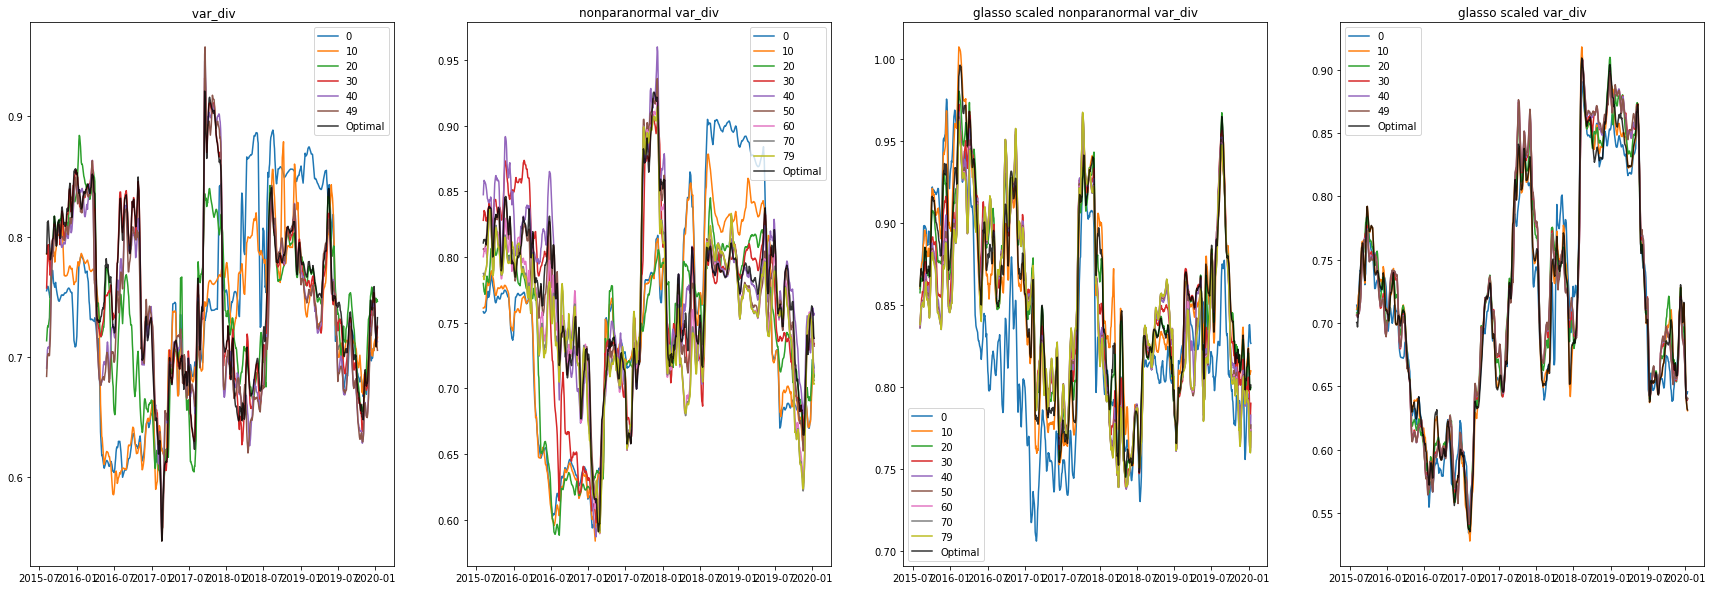

In [133]:
portfolio_type = 'gmv'
group = 0
metric = 'var_div'

fig, ax = plt.subplots(1,4, figsize = (30,10))
plot_regularization(scale_F_none, portfolio_type, group, metric, ax = ax[0], title = '')
plot_regularization(scale_F_nonparanormal, portfolio_type, group, metric, ax = ax[1], title = 'nonparanormal')
plot_regularization(scale_T_nonparanormal, portfolio_type, group, metric, ax = ax[2], title = 'glasso scaled nonparanormal')
plot_regularization(scale_T_none, portfolio_type, group, metric, ax = ax[3], title = 'glasso scaled')






# ALL

Load graphs

# 

We have to scale the data, otherwise lgrmf will put equal weights to all nodes giving a complete graph

In [59]:
with open(f'../data/Graphs/case_study_1_d_1_winlen_300_gest_huge_glasso_ebic_scale_None.pkl', 'rb') as f:
    data_dict = pickle.load(f)
data_dict[0].keys()

dict_keys(['dates', 'graph_dict', 'sector', 'cov_dict', 'GMV_portfolio_dict', 'max_sharpe_portfolio_dict', 'return_dict', 'window_size', 'stock_partition', 'gmv_div_dict', 'gmv_var_div_dict', 'sharpe_div_dict', 'sharpe_var_div_dict', 'uni_div_dict', 'uni_var_div_dict', 'cov_dict2', 'GMV_portfolio_dict2', 'max_sharpe_portfolio_dict2', 'return_dict2', 'gmv_div_dict2', 'gmv_var_div_dict2', 'sharpe_div_dict2', 'sharpe_var_div_dict2', 'uni_div_dict2', 'uni_var_div_dict2'])

Plot graph statistics

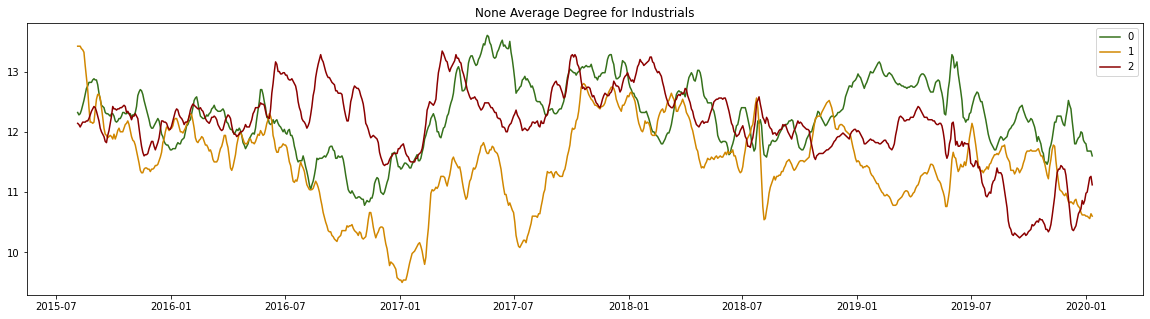

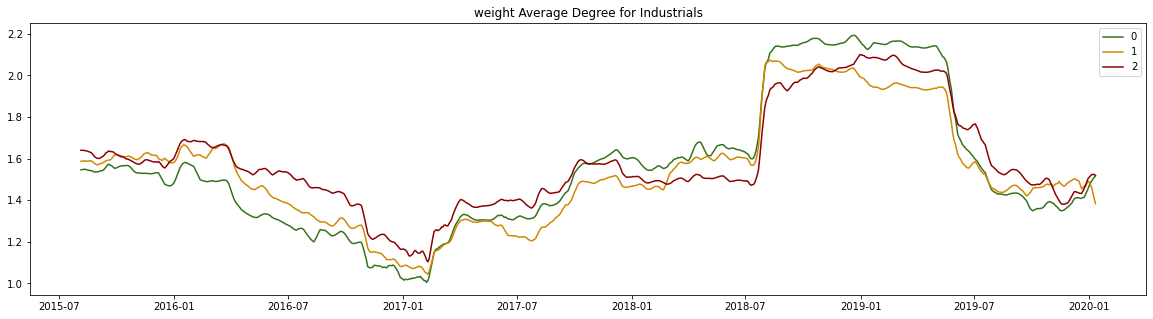

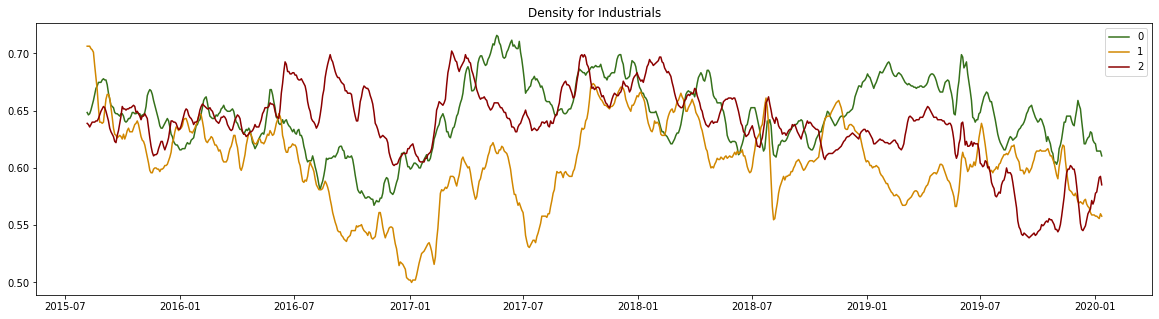

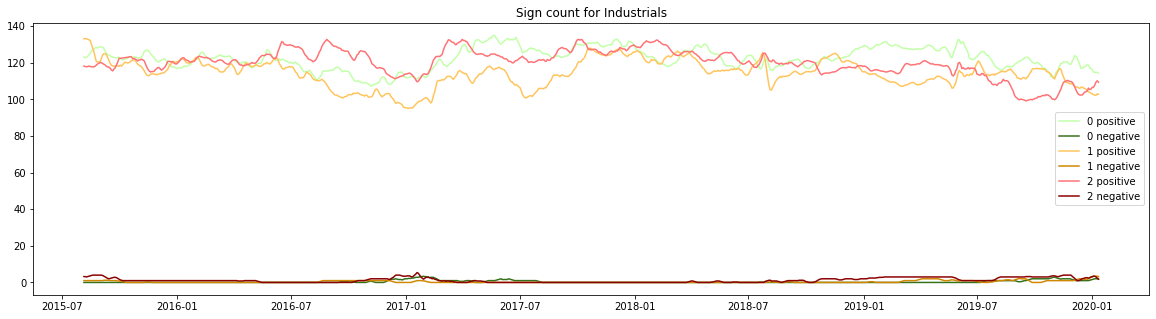

In [60]:

for idx in range(len(data_dict)):
    fig, ax = plt.subplots(1,1, figsize = (20,5))
    plot_avg_degree(data_dict[idx], ax = ax)
    fig, ax = plt.subplots(1,1, figsize = (20,5))
    plot_avg_degree(data_dict[idx], weight = 'weight', ax = ax)
    fig, ax = plt.subplots(1,1, figsize = (20,5))
    plot_G_density(data_dict[idx], ax = ax)
    fig, ax = plt.subplots(1,1, figsize = (20,5))
    plot_G_signs(data_dict[idx], ax = ax)
    

In [ ]:
data_dict['graph_dict']

Plot example graphs

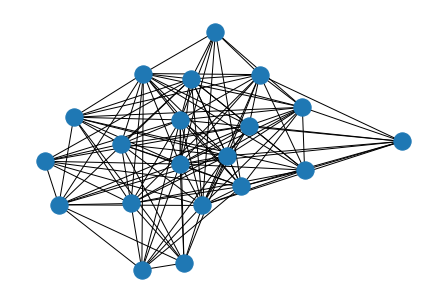

In [220]:
nx.draw(data_dict[0]['graph_dict'][0][300])

Look at if the splits are uniform

In [243]:
data_dict[idx]['sector']

'Industrials'

In [195]:
data_dict[idx]['stock_partition'][0][0]

array(['APD', 'KMI', 'IFF', 'NEM', 'WMB', 'CMS', 'ES', 'SLB', 'EMN',
       'OKE', 'LYB', 'XEL', 'ECL', 'EXC', 'COP', 'EIX', 'PEG', 'HES',
       'HAL', 'MPC'], dtype=object)

<AxesSubplot:>

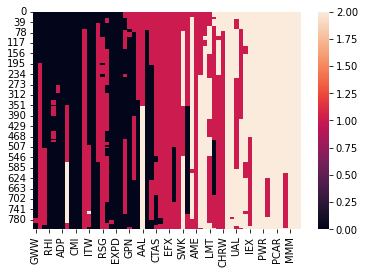

In [67]:
unique_stocks =np.concatenate((data_dict[idx]['stock_partition'][0][0],data_dict[idx]['stock_partition'][1][0],data_dict[idx]['stock_partition'][2][0]))
n = len(data_dict[idx]['stock_partition'][0])
p = len(unique_stocks)
unique_stocks = pd.DataFrame(np.zeros((n,p)), columns= unique_stocks)

for col in unique_stocks.columns:
    for i in range(len(data_dict[idx]['stock_partition'][0])):
        for j in range(3):
            if col in data_dict[idx]['stock_partition'][j][i]:
                unique_stocks[col].iloc[i] = j
                continue

sns.heatmap(unique_stocks)

Count number proportion of sector in each ckass

In [222]:
n = len(data_dict[idx]['stock_partition'][0])
p = 11
sector_count = pd.DataFrame(np.zeros((n*3,12)), columns= np.concatenate((list(sector_classification.keys()), ["group"])))

for k in sector_classification.keys():
    for i in range(len(data_dict[idx]['stock_partition'][0])):
        for j in range(3):
            cnt = np.sum(np.isin(data_dict[idx]['stock_partition'][j][i], sector_classification[k]))
            sector_count[k].iloc[(i*3)+j] = cnt
            sector_count['group'].iloc[(i*3)+j] = j


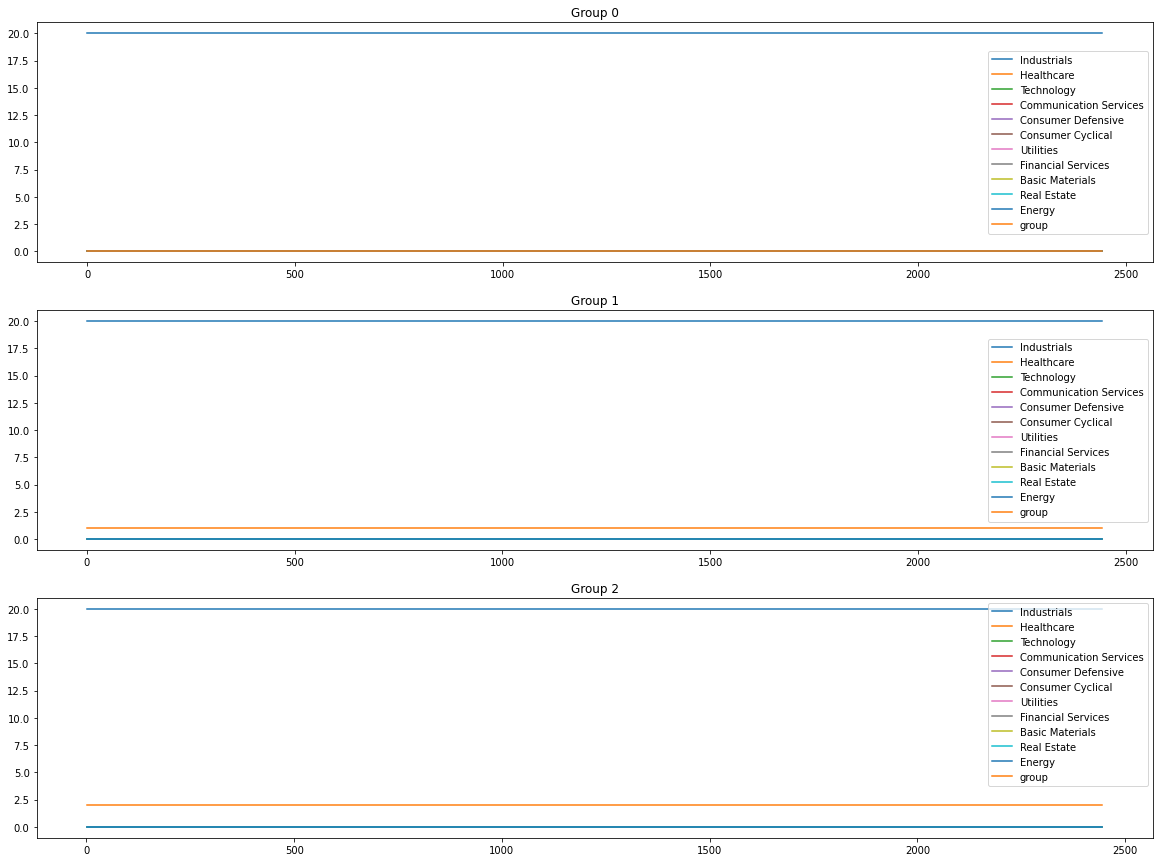

In [224]:
fig, ax = plt.subplots(3,1, figsize = (20,15))
for j in range(3):
    # [['Utilities', 'Energy', 'Basic Materials']]
    sector_count.loc[sector_count['group'] == j].plot(ax = ax[j], title = f'Group {j}')



Plot weights

(-10.0, 10.0)

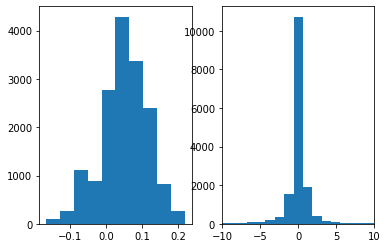

In [247]:
fig, ax = plt.subplots(1,2)
_ = ax[0].hist(np.hstack(data_dict[idx]['GMV_portfolio_dict'][0]))
_ = ax[1].hist(np.hstack(data_dict[idx]['max_sharpe_portfolio_dict'][0]), bins = 1000)
ax[1].set_xlim([-10,10])

Plot diversification

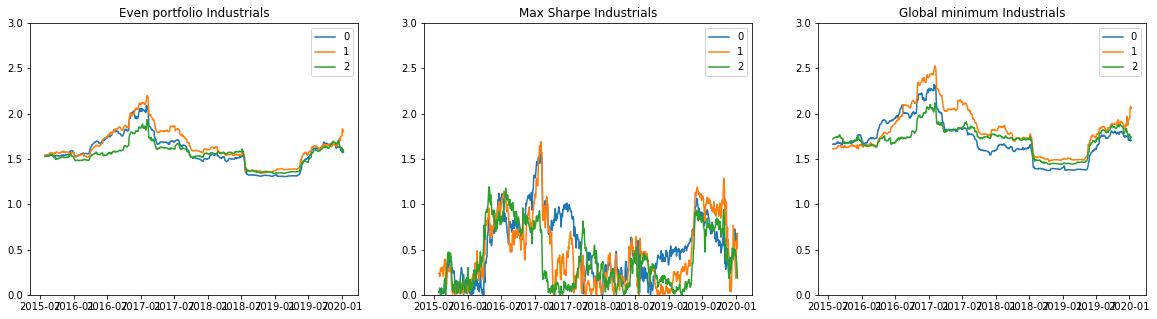

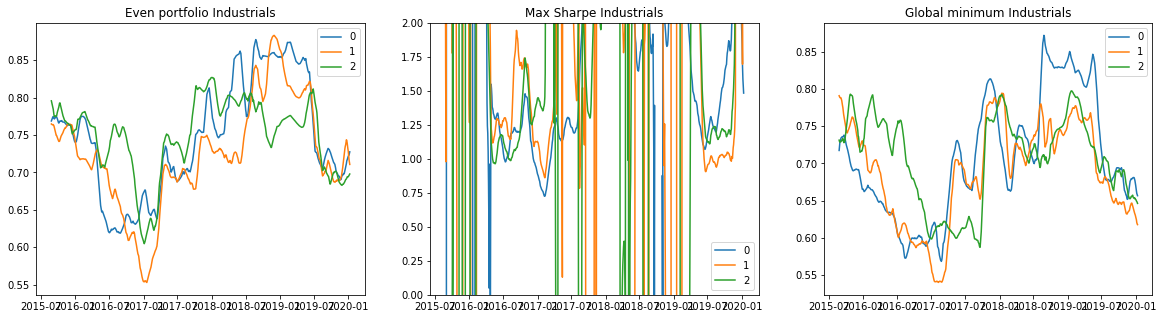

In [248]:
for idx in range(len(data_dict)):
    sector = data_dict[idx]['sector']


    fig, ax = plt.subplots(1,3, figsize = (20,5))
    pd.DataFrame(data_dict[idx]['uni_div_dict'], index = data_dict[idx]['dates']).plot(ax = ax[0], title = f'Even portfolio {sector}', ylim = [0,3])
    pd.DataFrame(data_dict[idx]['sharpe_div_dict'], index = data_dict[idx]['dates']).plot(ax = ax[1], title = f'Max Sharpe {sector}', ylim = [0,3])
    pd.DataFrame(data_dict[idx]['gmv_div_dict'], index = data_dict[idx]['dates']).plot(ax = ax[2], title = f'Global minimum {sector}', ylim = [0,3])

    #fig, ax = plt.subplots(1,3, figsize = (20,5))
    #pd.DataFrame(data_dict[idx]['uni_var_div_dict'], index = data_dict[idx]['dates']).plot(ax = ax[0], title = f'Even portfolio {sector}' )
    #pd.DataFrame(data_dict[idx]['sharpe_var_div_dict'], index = data_dict[idx]['dates']).plot(ax = ax[1], title = f'Max Sharpe {sector}')
    #pd.DataFrame(data_dict[idx]['gmv_var_div_dict'], index = data_dict[idx]['dates']).plot(ax = ax[2], title = f'Global minimum {sector}')

    fig, ax = plt.subplots(1,3, figsize = (20,5))
    pd.DataFrame(data_dict[idx]['uni_var_div_dict'], index = data_dict[idx]['dates']).rolling(15).mean().plot(ax = ax[0], title = f'Even portfolio {sector}' )
    pd.DataFrame(data_dict[idx]['sharpe_var_div_dict'], index = data_dict[idx]['dates']).rolling(15).mean().plot(ax = ax[1], title = f'Max Sharpe {sector}',ylim = [0,2])
    pd.DataFrame(data_dict[idx]['gmv_var_div_dict'], index = data_dict[idx]['dates']).rolling(15).mean().plot(ax = ax[2], title = f'Global minimum {sector}')

Look at mmd

In [168]:
scale = True
trans = None# 'nonparanormal'
rw = 'weight'
ptype = 'uniform'
glabel = None# "signed" #None
with open(f'../data/mmd_test/TEST_d_1_winlen_300_gest_huge_glasso_ebic_scale_{scale}_trans_{trans}_n_20_B_5000_rw_{rw}_dstep_10_glabel_{glabel}_wfun_None_p_{ptype}.pkl', 'rb') as f:
    test_info = pickle.load(f)
test_info[0].keys()

with open(f'../data/Graphs/TEST_d_1_winlen_300_gest_huge_glasso_ebic_scale_{scale}_trans_{trans}.pkl', 'rb') as f:
    data_dict = pickle.load(f)



check if hyperparameter stayed the same throughout

(array([67.,  0.,  2.,  2.,  1.,  2.,  0.,  1.,  0.,  2.]),
 array([0.   , 0.081, 0.162, 0.243, 0.324, 0.405, 0.486, 0.567, 0.648,
        0.729, 0.81 ]),
 <BarContainer object of 10 artists>)

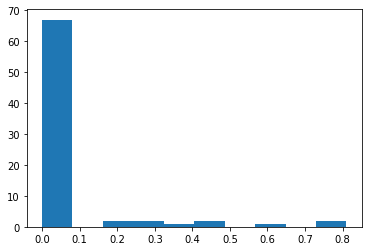

In [169]:
plt.hist(test_info[0]['info_dict']['MMD_u'])

In [62]:
test_info[0]['info_dict']

sector  group_i  group_j   MMD_u   MMD_b   MMD_l kernel   r  \
0   Industrials        0        2  0.0000  0.0000  0.0002     rw  12   
1   Industrials        0        2  0.0000  0.0000  0.0044     rw  12   
2   Industrials        0        2  0.0006  0.0006  0.0502     rw  12   
3   Industrials        0        2  0.0000  0.0000  0.0000     rw  12   
4   Industrials        0        2  0.0000  0.0000  0.0000     rw  12   
..          ...      ...      ...     ...     ...     ...    ...  ..   
72  Industrials        0        2  0.0000  0.0000  0.0004     rw  12   
73  Industrials        0        2  0.0000  0.0000  0.0000     rw  12   
74  Industrials        0        2  0.0000  0.0000  0.0000     rw  12   
75  Industrials        0        2  0.0000  0.0000  0.0000     rw  12   
76  Industrials        0        2  0.0000  0.0000  0.0000     rw  12   

               c       dates   dates_mid  
0   1.000000e-09  2016-01-08  2015-12-09  
1   1.000000e-09  2016-02-08  2016-01-08  
2   1.000000e-09  2016-03-08  2016-02-08  
3   1.000000e-09  2016-04-06  2016-03-08  
4   1.000000e-09  2016-05-04  2016-04-06  
..           ...         ...         ...  
72  1.000000e-09  2021-09-28  2021-08-30  
73  1.000000e-09  2021-10-26  2021-09-28  
74  1.000000e-09  2021-11-23  2021-10-26  
75  1.000000e-09  2021-12-22  2021-11-23  
76  1.000000e-09  2022-01-21  2021-12-22  

[77 rows x 11 columns]

In [231]:
print(np.unique(test_info[0]['info_dict']['c']))
print(np.unique(test_info[0]['n']))

[1.e-11]
[20]


In [21]:
data_dict[idx]['portfolios_info']['uniform'].keys()

dict_keys(['weights', 'cov_div', 'var_div', 'omega', 'sharpe', 'sortino', 'beta', 'treynor'])

 Plot mmd and compare with diversification

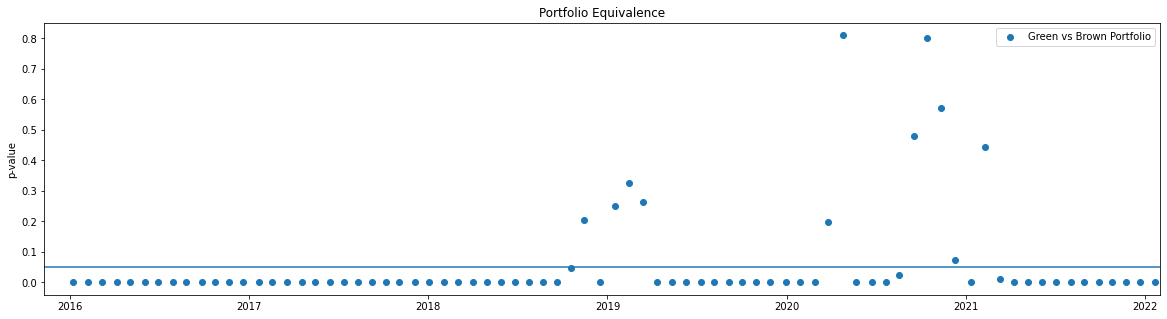

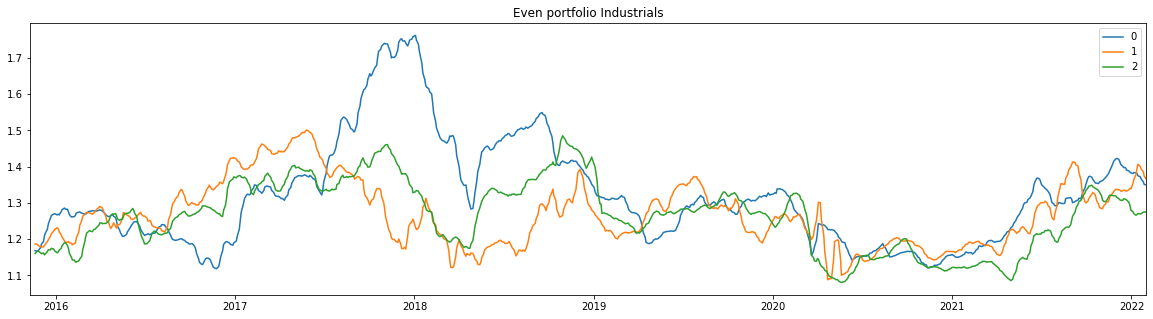

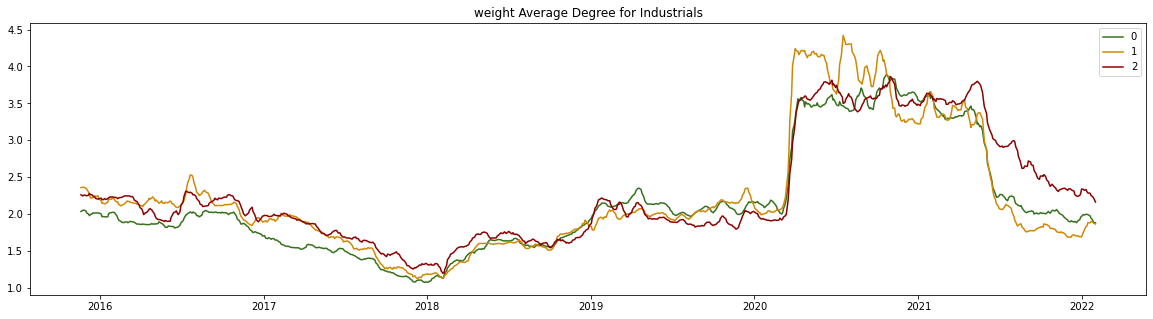

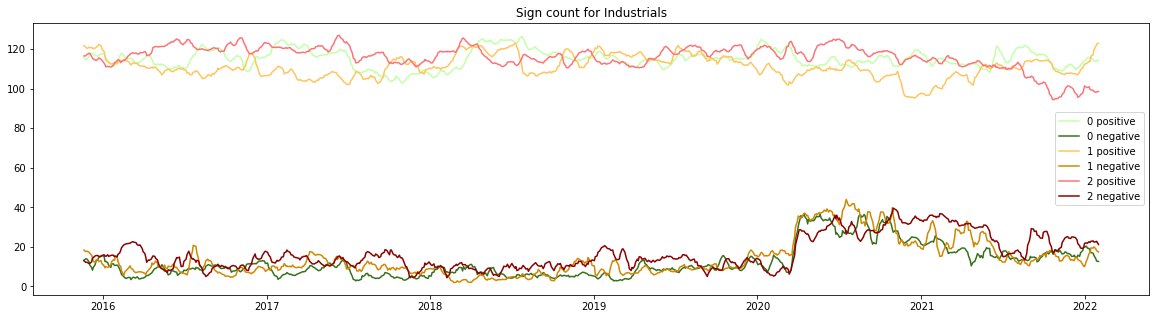

In [170]:

for idx in range(len(test_info)):
    tmp = test_info[idx]['info_dict']
    sector = test_info[idx]['sector']
    fig ,ax = plt.subplots(1,1, figsize = (20,5))

    tmp['id'] = tmp['group_i'].astype(str) + tmp['group_j'].astype(str) 
    for id in ["02"]:#np.unique(tmp['id']):
        #ax.plot(tmp['dates'].loc[tmp['id'] == id], tmp['MONK_EST'].loc[tmp['id'] == id], label = "monk")
        tmp_tmp = tmp.loc[tmp['id'] == id]

        #ax.plot(tmp['dates'].loc[tmp['id'] == id], tmp['MMD_u'].loc[tmp['id'] == id].rolling(1).mean(), label = "Green vs Brown Portfolio")
        ax.scatter(tmp['dates'].loc[tmp['id'] == id], tmp['MMD_u'].loc[tmp['id'] == id], label = 'Green vs Brown Portfolio')
    ax.axhline(y = 0.05)
    ax.legend()
    ax.set_title('Portfolio Equivalence')
    ax.set_ylabel('p-value')
    ax.set_xlim([np.min(data_dict[idx]['dates']), np.max((np.max(data_dict[idx]['dates']),np.max(tmp['dates'])))])

    fig, ax = plt.subplots(1,1, figsize = (20,5))
    metric = 'cov_div'
    pd.DataFrame(data_dict[idx]['portfolios_info']['sharpe'][metric], index = data_dict[idx]['dates']).rolling(5).mean().plot(ax = ax, title = f'Even portfolio {sector}' )
    #pd.DataFrame(data_dict[idx]['portfolios_info']['sharpe'][metric], index = data_dict[idx]['dates']).rolling(5).mean().plot(ax = ax[1], title = f'Max Sharpe {sector}')
    #pd.DataFrame(data_dict[idx]['portfolios_info']['gmv'][metric], index = data_dict[idx]['dates']).rolling(5).mean().plot(ax = ax[2], title = f'Global minimum {sector}')
    ax.set_xlim([np.min(data_dict[idx]['dates']), np.max((np.max(data_dict[idx]['dates']),np.max(tmp['dates'])))])
    #ax[1].set_xlim([np.min(data_dict[idx]['dates']), np.max((np.max(data_dict[idx]['dates']),np.max(tmp['dates'])))])
    #ax[2].set_xlim([np.min(data_dict[idx]['dates']), np.max((np.max(data_dict[idx]['dates']),np.max(tmp['dates'])))])

    fig, ax = plt.subplots(1,1, figsize = (20,5))
    plot_avg_degree(data_dict[idx], weight = 'weight', ax = ax)
    fig, ax = plt.subplots(1,1, figsize = (20,5))
    plot_G_signs(data_dict[idx], ax = ax)

In [95]:
def div_ratio(w, cov):
  # numerator is perfect correlation
  # denom is portfolio risk
  # np.inner(w, np.sqrt(np.diag(cov)))/
  return np.sqrt(np.dot(w, cov).dot(w))

In [94]:
i = 200
cov1 = data_dict[0]['cov_dict'][0][i]
cov2 = data_dict[0]['cov_dict'][2][i]
print(data_dict[0]['dates'][i])
w = np.ones(cov1.shape[1])/float(cov1.shape[1])
print(div_ratio(w,cov1))
print(div_ratio(w,cov2))
print(data_dict[0]['portfolios_info']['uniform']['cov_div'][0][i])
print(data_dict[0]['portfolios_info']['uniform']['cov_div'][2][i])

2017-06-14
8.322024295730323
8.222902607589214
1.5217061664895564
1.4556077985046172


Let's test manually. Seems like there is some fishyness going on

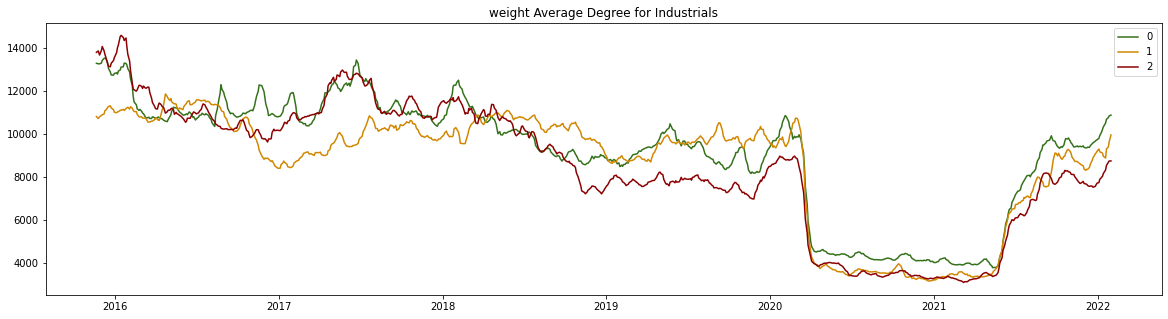

In [156]:
scale = False
trans = 'nonparanormal'
with open(f'../data/Graphs/TEST_d_1_winlen_300_gest_huge_glasso_ebic_scale_{scale}_trans_{trans}.pkl', 'rb') as f:
    data_dict = pickle.load(f)

fig, ax = plt.subplots(1,1, figsize = (20,5))
plot_avg_degree(data_dict[0], weight = 'weight', ax = ax)

In [4]:
index = np.where((data_dict[0]['dates'] > datetime.date(2017,11,1)) & (data_dict[0]['dates'] <= datetime.date(2018,1,1)))[0]
print(len(index))
index = index[:20]

20


In [87]:
from util import avg_degree
# G1 = [nx.from_numpy_array(nx.adjacency_matrix(data_dict[0]['graph_dict'][0][i]).todense()/1000) for i in index] 
# G2 = [nx.from_numpy_array(nx.adjacency_matrix(data_dict[0]['graph_dict'][2][i]).todense()/1000) for i in index]
G1 = [data_dict[0]['graph_dict'][0][i] for i in index] 
G2 = [data_dict[0]['graph_dict'][2][i] for i in index]
for j,i in enumerate(index):
    nx.set_node_attributes(G1[j], {key: [value] for key, value in enumerate(data_dict[0]['portfolios_info']['sharpe']['weights'][0][i])},'attr')
for j,i in enumerate(index):
    nx.set_node_attributes(G2[j], {key: [value] for key, value in enumerate(data_dict[0]['portfolios_info']['sharpe']['weights'][2][i])},'attr')

Gs = G1 + G2
#Gs = [nx.from_numpy_array(np.abs(nx.adjacency_matrix(Gs[k]).todense())) for k in range(len(Gs))]

def degreelabels( G):

    nodes_degree = dict(G.degree)
    return {key: str(value) for key, value in nodes_degree.items()}

for i in range(len(Gs)):
    nx.set_node_attributes(Gs[i], degreelabels(Gs[i]),'label')




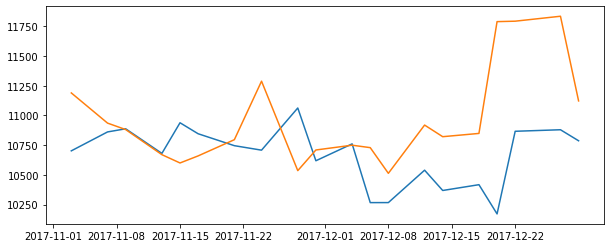

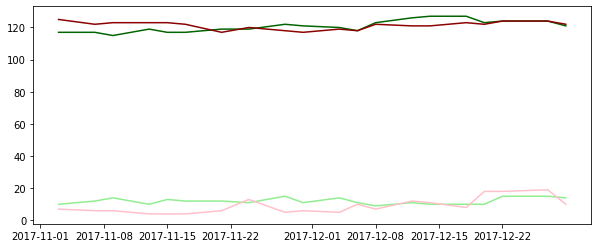

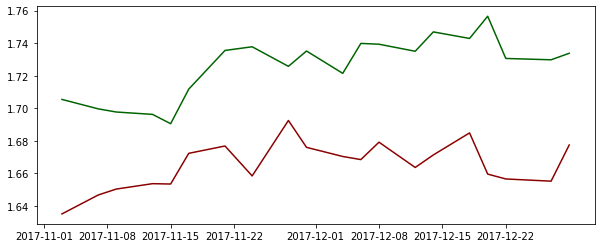

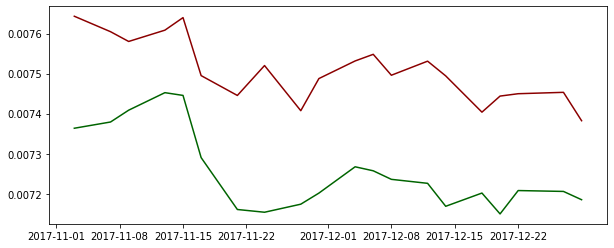

In [96]:
fig,ax = plt.subplots(1,1, figsize = (10,4))
ax.plot(data_dict[0]['dates'][index], [avg_degree(G1[i], 'weight') for i in range(len(G1))])
ax.plot(data_dict[0]['dates'][index], [avg_degree(G2[i], 'weight') for i in range(len(G2))])

fig,ax = plt.subplots(1,1, figsize = (10,4))
ax.plot(data_dict[0]['dates'][index], [cnt_pos_neg(G1[i], 1) for i in range(len(G1))], color = "DarkGreen")
ax.plot(data_dict[0]['dates'][index], [cnt_pos_neg(G1[i], -1) for i in range(len(G1))], color = "lightgreen")

ax.plot(data_dict[0]['dates'][index], [cnt_pos_neg(G2[i], 1) for i in range(len(G2))], color = "Darkred")
ax.plot(data_dict[0]['dates'][index], [cnt_pos_neg(G2[i], -1) for i in range(len(G2))], color = "pink")

fig,ax = plt.subplots(1,1, figsize = (10,4))
ax.plot(data_dict[0]['dates'][index], [data_dict[0]['portfolios_info']['uniform']['cov_div'][0][i] for i in index], color = "Darkgreen")
ax.plot(data_dict[0]['dates'][index], [data_dict[0]['portfolios_info']['uniform']['cov_div'][2][i] for i in index], color = "Darkred")

fig,ax = plt.subplots(1,1, figsize = (10,4))
ax.plot(data_dict[0]['dates'][index], [div_ratio(w,data_dict[0]['cov_dict'][0][i]) for i in index], color = "Darkgreen")
ax.plot(data_dict[0]['dates'][index], [div_ratio(w,data_dict[0]['cov_dict'][2][i]) for i in index], color = "Darkred")

In [113]:
A1 = np.linalg.inv(data_dict[0]['cov_dict'][0][index[0]])
A1[np.abs(A1)<1e-5] = 0
A2 = np.linalg.inv(data_dict[0]['cov_dict'][2][index[0]])
A2[np.abs(A2)<1e-5] = 0
G1 = nx.from_numpy_array(A1)
G2 = nx.from_numpy_array(A2)

In [129]:
data_dict[0]['cov_dict'][2][index[0]]

array([[8.30878680e-05, 2.92205097e-05, 3.28477697e-05, 2.43139635e-05,
        2.89565244e-05, 2.99289336e-05, 2.08103468e-05, 3.41365400e-05,
        2.61941686e-05, 3.35290716e-05, 2.90959747e-05, 2.73755352e-05,
        3.36379348e-05, 3.32276992e-05, 3.96909888e-05, 5.03671784e-05,
        3.10314136e-05, 3.49467451e-05, 4.23955786e-05, 1.90812666e-05],
       [2.92217894e-05, 1.36293698e-04, 5.51743821e-05, 5.68823401e-05,
        4.90480988e-05, 5.93122296e-05, 3.08626481e-05, 7.88157631e-05,
        4.06028325e-05, 8.32210645e-05, 6.49673293e-05, 6.96316343e-05,
        7.49031236e-05, 9.42819875e-05, 6.28788225e-05, 4.12294071e-05,
        7.59320712e-05, 4.39921061e-05, 5.41315430e-05, 4.10748780e-05],
       [3.28460509e-05, 5.51682947e-05, 3.52568523e-04, 6.35358721e-05,
        2.18151543e-04, 6.91581287e-05, 3.19986564e-05, 6.05183667e-05,
        4.28049750e-05, 5.29372747e-05, 5.60492685e-05, 5.72178395e-05,
        7.85296072e-05, 6.58563982e-05, 7.57399249e-05, 4.5963

In [126]:
l1,u1 = np.linalg.eigh(A1)
l1

array([  812.08520462,  3162.73257569,  3685.15091333,  4836.80485613,
        5964.81319713,  6727.36599668,  7497.55953154,  8583.97433732,
        9215.7778996 ,  9823.44572121, 11122.08353358, 11239.54929383,
       14006.48680943, 15858.06364247, 17085.88094644, 19216.22968412,
       21916.47475116, 22576.76896842, 24281.07329798, 26558.82793331])

In [125]:
l2,u2 = np.linalg.eigh(A2)
l2

array([  809.46207516,  2559.97558499,  4713.25662016,  5983.24414286,
        7456.38826047,  7927.91850665,  9155.90144145, 10218.68960698,
       10927.13899187, 11563.74383674, 11680.4775167 , 12035.59235774,
       13180.92041696, 13933.04362667, 15148.92329819, 17873.96183998,
       18345.58264356, 22673.54856926, 25225.02917276, 28864.58443318])

In [118]:
np.mean(list(G1.degree(weight = 'weight')),axis = 0)

array([9.50000000e+00, 1.37146897e+04])

In [119]:
np.mean(list(G2.degree(weight = 'weight')),axis = 0)

array([9.50000000e+00, 1.38385124e+04])

In [154]:
sys.path.insert(0, 'C:/Users/User/Code/MMD_Graph_Diversification')
sys.path.insert(0, 'C:/Users/User/Code/MMD_Graph_Diversification/myKernels')

import MMDforGraphs as mg
from myKernels import RandomWalk as rw
import grakel as gk
n = len(G1)
# weights = data_dict[0]['portfolios_info']['uniform']['weights']
# p =  np.vstack(([ weights[0][s] for s in index],[ weights[2][s] for s in index]))
rw_kernel = rw.RandomWalk(Gs, c = 1e-11, normalize=0, p = p)
K = rw_kernel.fit_ARKU_plus(r = 10, normalize_adj=False, verbose=False, edge_attr= 'weight')
# K  = rw_kernel.fit_random_walk(r = 10, k = 3, mu_vec=[0,0,1,1])
# K = rw_kernel.fit_ARKU_edge(r = 6, edge_labels = [1,-1], verbose=False, edge_attr = 'weight', edge_label_tag='sign')

## Grakel kernels
# graph_list = gk.graph_from_networkx(Gs, node_labels_tag='attr')  # Convert to graphs to Grakel format 
# kernel = [{"name": "propagation", "t_max": 4, "w":0.01, "M":'L1','with_attributes':True}]
# init_kernel = gk.GraphKernel(kernel= kernel, normalize=0)
# K = init_kernel.fit_transform(graph_list)

MMD_functions = [mg.MMD_b, mg.MMD_u, mg.MMD_l]#, mg.MONK_EST]
kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
function_arguments = [dict(n = n, m = n  ), 
                    dict(n = n, m = n ),
                    dict(n = n, m = n )]#, 
                    #dict(Q = 3, y1 = Gs[:bg1.n], y2 = Gs[bg1.n:] )]
                    #dict(Q = 5, y1 = list(range(n)), y2 = list(range(n, n+n)) )]
kernel_hypothesis.Bootstrap(K, function_arguments, B = 3000)





# Run power
#print(f'V {V}')
#print(f'ratio {ratio}')
#print(f'power {power}')
print(f'p_value {kernel_hypothesis.p_values}')
#print(f"MMD_u {kernel_hypothesis.sample_test_statistic['MMD_u']}")

l, _= np.linalg.eigh(K)
l


p_value {'MMD_b': 0.022, 'MMD_u': 0.022, 'MMD_l': 0.006}


array([-2.90492822e-17, -2.10951431e-17, -1.68622243e-17, -1.33873897e-17,
       -1.25599148e-17, -9.89627609e-18, -8.79145692e-18, -8.28850569e-18,
       -6.38810396e-18, -5.91475230e-18, -4.88720488e-18, -4.51346376e-18,
       -3.80253495e-18, -2.91260330e-18, -1.80137173e-18, -1.38243254e-18,
       -1.10159310e-18, -1.93685932e-19,  3.18490359e-20,  6.74354237e-19,
        1.35096513e-18,  1.38137676e-18,  2.14803569e-18,  2.54980897e-18,
        3.27265521e-18,  3.31388147e-18,  4.56044668e-18,  4.76124862e-18,
        4.80947493e-18,  5.81865331e-18,  7.38218704e-18,  8.21557504e-18,
        1.03734877e-17,  1.26828336e-17,  1.60876972e-17,  2.08108018e-17,
        7.04210335e-15,  1.10899406e-10,  1.29277870e-07,  1.00117469e-01])

<AxesSubplot:>

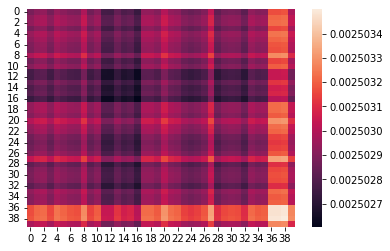

In [155]:
import seaborn as sns
sns.heatmap(K)

In [199]:
sys.path.insert(0, 'C:/Users/User/Code/MMD_Graph_Diversification')
sys.path.insert(0, 'C:/Users/User/Code/MMD_Graph_Diversification/myKernels')

import MMDforGraphs as mg
from myKernels import RandomWalk as rw
n = len(G1)
rw_kernel = rw.RandomWalk(Gs, c = 1e-11, normalize=0)
K = rw_kernel.fit_ARKU_edge(r = 10, verbose=False, edge_attr= 'weight', edge_label_tag='sign', edge_labels=[-1,1])

MMD_functions = [mg.MMD_b, mg.MMD_u, mg.MMD_l]#, mg.MONK_EST]
kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
function_arguments = [dict(n = n, m = n  ), 
                    dict(n = n, m = n ),
                    dict(n = n, m = n )]#, 
                    #dict(Q = 3, y1 = Gs[:bg1.n], y2 = Gs[bg1.n:] )]
                    #dict(Q = 5, y1 = list(range(n)), y2 = list(range(n, n+n)) )]
kernel_hypothesis.Bootstrap(K, function_arguments, B = 5000)

# Run power
#print(f'V {V}')
#print(f'ratio {ratio}')
#print(f'power {power}')
print(f'p_value {kernel_hypothesis.p_values}')
#print(f"MMD_u {kernel_hypothesis.sample_test_statistic['MMD_u']}")
np.linalg.eigh(K)

p_value {'MMD_b': 0.0016, 'MMD_u': 0.0016, 'MMD_l': 0.0008}


(array([-3.04361151e-18, -1.87432837e-18, -8.16073124e-19, -7.90413354e-19,
        -4.80104732e-19, -4.26341551e-19, -2.60279897e-19, -1.59458189e-19,
        -4.92397067e-20,  1.17848384e-19,  3.30278417e-19,  4.13062938e-19,
         4.70179780e-19,  5.28978674e-19,  8.16737152e-19,  6.88896258e-18,
         3.38865904e-16,  3.22390023e-14,  2.38554625e-11,  5.01272326e-09,
         7.77165913e-08,  5.50686528e-02]),
 array([[ 7.77563888e-01, -2.99978074e-01,  2.96383426e-02,
          2.57293896e-02,  2.37249930e-02,  6.72891354e-02,
         -3.36151663e-02,  1.27022750e-01,  4.23045262e-02,
         -2.70741188e-02, -1.08977784e-01, -9.03940579e-02,
          3.27786271e-02, -3.30669421e-02,  4.21102995e-03,
         -3.35884054e-01, -1.84789610e-01,  6.95208037e-02,
         -8.82084224e-02, -2.12489918e-01,  8.10648758e-02,
          2.13198260e-01],
        [ 3.29922302e-01,  3.47112402e-01, -9.38109866e-03,
          7.39185881e-03, -5.94994734e-03, -4.93060126e-02,
         

In [97]:
sys.path.insert(0, 'C:/Users/User/Code/MMD_Graph_Diversification')
sys.path.insert(0, 'C:/Users/User/Code/MMD_Graph_Diversification/myKernels')

import MMDforGraphs as mg
from myKernels import RandomWalk as rw
n = len(G1)
rw_kernel = rw.RandomWalk(Gs, c = 0.0001, normalize=0)
K = rw_kernel.fit_ARKU_edge(r = 10, verbose=False, edge_attr= None, edge_label_tag='sign', edge_labels=[-1,1])

MMD_functions = [mg.MMD_b, mg.MMD_u, mg.MMD_l, mg.MONK_EST]
kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
function_arguments = [dict(n = n, m = n  ), 
                    dict(n = n, m = n ),
                    dict(n = n, m = n ), 
                    #dict(Q = 3, y1 = Gs[:bg1.n], y2 = Gs[bg1.n:] )]
                    dict(Q = 5, y1 = list(range(n)), y2 = list(range(n, n+n)) )]
kernel_hypothesis.Bootstrap(K, function_arguments, B = 5000)

# Run power
#print(f'V {V}')
#print(f'ratio {ratio}')
#print(f'power {power}')
print(f'p_value {kernel_hypothesis.p_values}')
#print(f"MMD_u {kernel_hypothesis.sample_test_statistic['MMD_u']}")

C:/Users/User/Code/MMD_Graph_Diversification\myKernels\RandomWalk.py:975: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A[idx] = scipy.sparse.csr_matrix(np.abs(nx.linalg.adjacency_matrix(G_tmp, weight = edge_attr)), dtype=np.float64)


p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MMD_l': 0.0, 'MONK_EST': 0.0}


In [108]:
import grakel as gk
n = len(G1)
graph_list = gk.graph_from_networkx(Gs, node_labels_tag='label')  # Convert to graphs to Grakel format
kernel = [{"name": "weisfeiler_lehman", "n_iter": 1}, {"name": "vertex_histogram"}]
init_kernel = gk.GraphKernel(kernel= kernel, normalize=0)
K = init_kernel.fit_transform(graph_list)

MMD_functions = [mg.MMD_b, mg.MMD_u, mg.MMD_l, mg.MONK_EST]
kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
function_arguments = [dict(n = n, m = n  ), 
                    dict(n = n, m = n ),
                    dict(n = n, m = n ), 
                    #dict(Q = 3, y1 = Gs[:bg1.n], y2 = Gs[bg1.n:] )]
                    dict(Q = 5, y1 = list(range(n)), y2 = list(range(n, n+n)) )]
kernel_hypothesis.Bootstrap(K, function_arguments, B = 5000)

# Run power
#print(f'V {V}')
#print(f'ratio {ratio}')
#print(f'power {power}')
print(f'p_value {kernel_hypothesis.p_values}')
#print(f"MMD_u {kernel_hypothesis.sample_test_statistic['MMD_u']}")


p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MMD_l': 0.0, 'MONK_EST': 0.0988}


<AxesSubplot:>

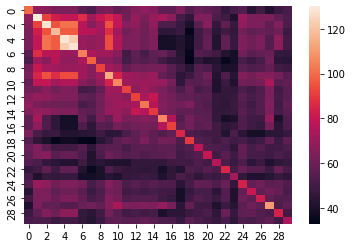

In [90]:
import seaborn as sns
sns.heatmap(K)

# Sklean glasso using 3 folds

In [7]:
with open(f'../data/Graphs/case_study_1_d_1_winlen_150_gest_sklearn_glasso_scale_None.pkl', 'rb') as f:
    data_dict = pickle.load(f)
data_dict[0].keys()

FileNotFoundError: [Errno 2] No such file or directory: '../data/Graphs/TEST_d_1_winlen_300_gest_huge_glasso_ebic_scale_True_trans_None_n_30_B_5000_rw_weight_dstep_10_glabel_None_wfun_None.pkl'

Graph statistics

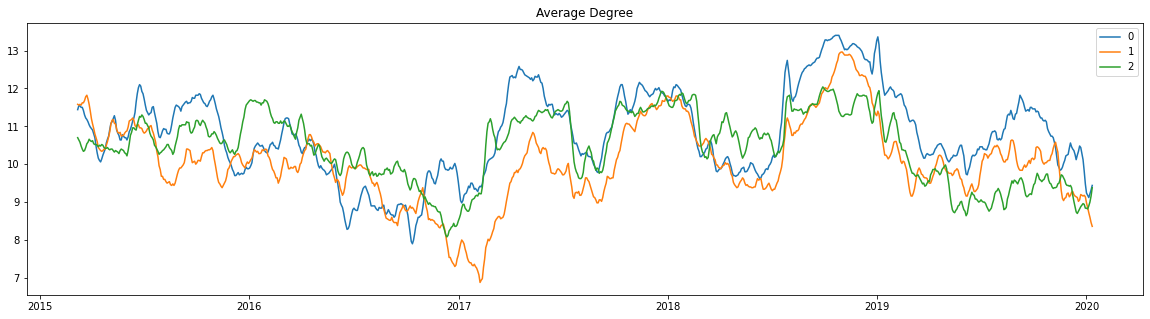

In [262]:
for idx in range(len(data_dict)):

    avg_deg_0 = [np.mean([j for i, j in data_dict[idx]['graph_dict'][0][j].degree]) for j in range(len(data_dict[idx]['graph_dict'][0]))]
    avg_deg_1 = [np.mean([j for i, j in data_dict[idx]['graph_dict'][1][j].degree]) for j in range(len(data_dict[idx]['graph_dict'][1]))] 
    avg_deg_2 = [np.mean([j for i, j in data_dict[idx]['graph_dict'][2][j].degree]) for j in range(len(data_dict[idx]['graph_dict'][2]))]

    fig, ax = plt.subplots(1,1, figsize = (20,5))
    ax.plot(data_dict[idx]['dates'], pd.DataFrame(avg_deg_0).rolling(5).mean().iloc[:,0], label = 0)
    ax.plot(data_dict[idx]['dates'], pd.DataFrame(avg_deg_1).rolling(5).mean().iloc[:,0], label = 1) 
    ax.plot(data_dict[idx]['dates'], pd.DataFrame(avg_deg_2).rolling(5).mean().iloc[:,0], label = 2)
    ax.set_title('Average Degree')
    ax.legend() 

Histogram of portfolio weights

(-10.0, 10.0)

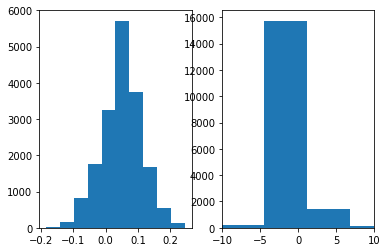

In [263]:
fig, ax = plt.subplots(1,2)
_ = ax[0].hist(np.hstack(data_dict[idx]['GMV_portfolio_dict'][0]))
_ = ax[1].hist(np.hstack(data_dict[idx]['max_sharpe_portfolio_dict'][0]), bins = 1000)
ax[1].set_xlim([-10,10])

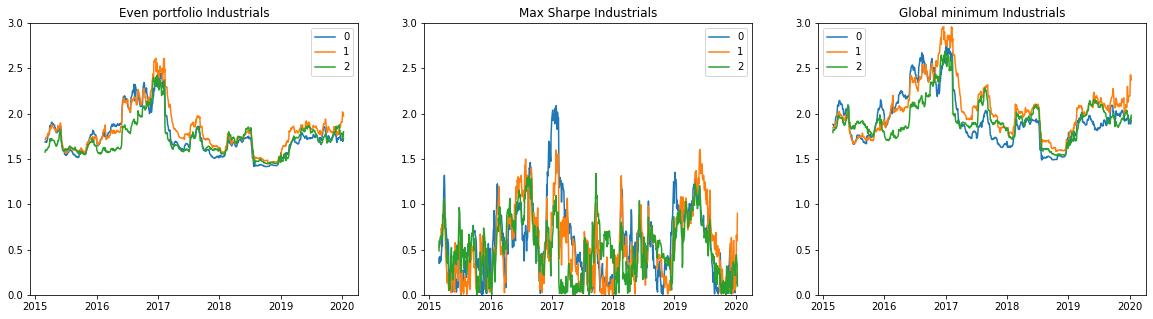

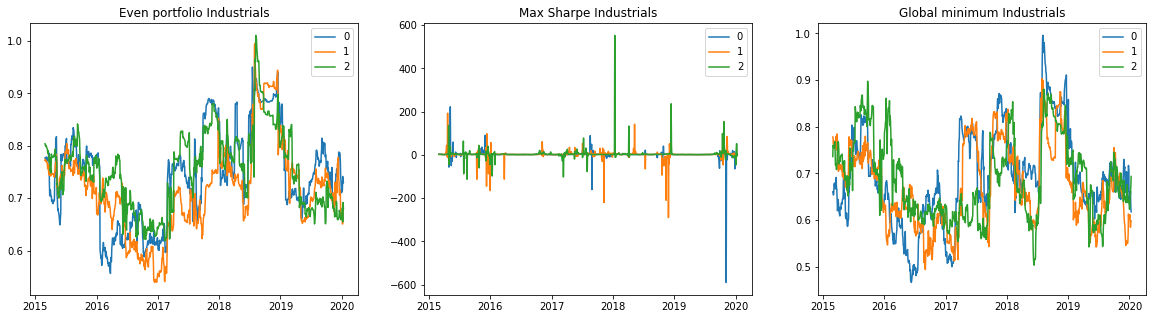

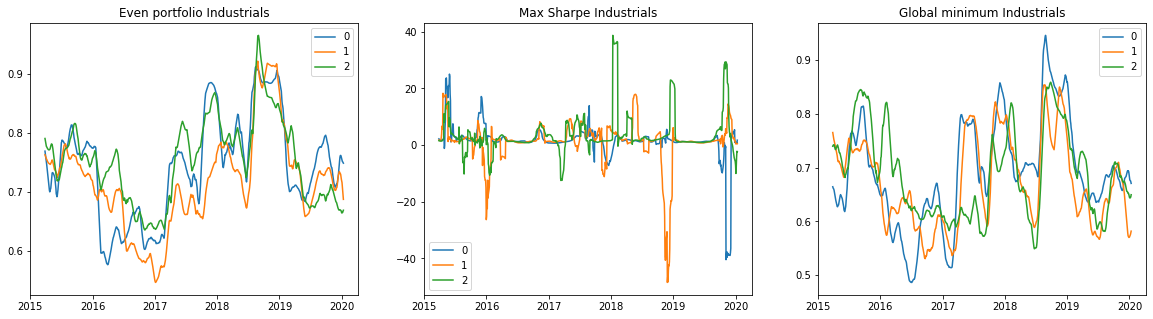

In [264]:
for idx in range(len(data_dict)):
    sector = data_dict[idx]['sector']


    fig, ax = plt.subplots(1,3, figsize = (20,5))
    pd.DataFrame(data_dict[idx]['uni_div_dict'], index = data_dict[idx]['dates']).plot(ax = ax[0], title = f'Even portfolio {sector}', ylim = [0,3])
    pd.DataFrame(data_dict[idx]['sharpe_div_dict'], index = data_dict[idx]['dates']).plot(ax = ax[1], title = f'Max Sharpe {sector}', ylim = [0,3])
    pd.DataFrame(data_dict[idx]['gmv_div_dict'], index = data_dict[idx]['dates']).plot(ax = ax[2], title = f'Global minimum {sector}', ylim = [0,3])

    fig, ax = plt.subplots(1,3, figsize = (20,5))
    pd.DataFrame(data_dict[idx]['uni_var_div_dict'], index = data_dict[idx]['dates']).plot(ax = ax[0], title = f'Even portfolio {sector}' )
    pd.DataFrame(data_dict[idx]['sharpe_var_div_dict'], index = data_dict[idx]['dates']).plot(ax = ax[1], title = f'Max Sharpe {sector}')
    pd.DataFrame(data_dict[idx]['gmv_var_div_dict'], index = data_dict[idx]['dates']).plot(ax = ax[2], title = f'Global minimum {sector}')

    fig, ax = plt.subplots(1,3, figsize = (20,5))
    pd.DataFrame(data_dict[idx]['uni_var_div_dict'], index = data_dict[idx]['dates']).rolling(15).mean().plot(ax = ax[0], title = f'Even portfolio {sector}' )
    pd.DataFrame(data_dict[idx]['sharpe_var_div_dict'], index = data_dict[idx]['dates']).rolling(15).mean().plot(ax = ax[1], title = f'Max Sharpe {sector}')
    pd.DataFrame(data_dict[idx]['gmv_var_div_dict'], index = data_dict[idx]['dates']).rolling(15).mean().plot(ax = ax[2], title = f'Global minimum {sector}')

# Huge Glasso EBIC

In [17]:
with open(f'../data/Graphs/case_study_1_d_1_winlen_300_gest_huge_glasso_ebic_scale_None.pkl', 'rb') as f:
    data_dict = pickle.load(f)
data_dict[0].keys()

dict_keys(['dates', 'graph_dict', 'sector', 'cov_dict', 'GMV_portfolio_dict', 'max_sharpe_portfolio_dict', 'return_dict', 'window_size', 'stock_partition', 'gmv_div_dict', 'gmv_var_div_dict', 'sharpe_div_dict', 'sharpe_var_div_dict', 'uni_div_dict', 'uni_var_div_dict', 'cov_dict2', 'GMV_portfolio_dict2', 'max_sharpe_portfolio_dict2', 'return_dict2', 'gmv_div_dict2', 'gmv_var_div_dict2', 'sharpe_div_dict2', 'sharpe_var_div_dict2', 'uni_div_dict2', 'uni_var_div_dict2'])

Plot graph statistics

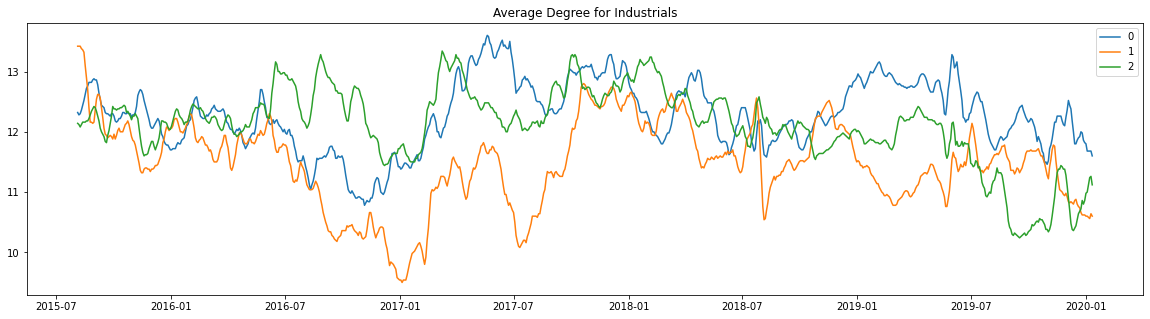

In [18]:
for idx in range(len(data_dict)):
    plot_avg_degree(data_dict[idx])

Look if companies are often jumping

# new